In [1]:
import math
import os
import shutil
import glob
from pyspark.sql.functions import col, regexp_replace, trim, split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
from scipy.stats import skew
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    avg, col, count, element_at, explode, kurtosis, lower, max, mean,
    percentile_approx, rank, regexp_extract, regexp_replace, round,
    size, skewness, split, stddev, substring, sum, trim, when
)

In [2]:
spark = SparkSession.builder \
    .appName("ChessAnalysisPipeline") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()
print("Spark Session created")

25/09/29 15:51:42 WARN Utils: Your hostname, LAPTOP-F72KGDAA resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/09/29 15:51:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/29 15:51:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session created


In [3]:
# Add memory monitoring function first (only add this once at the top)
import psutil
def check_memory():
    memory_mb = psutil.Process().memory_info().rss / 1024 / 1024
    print(f"💾 Memory usage: {memory_mb:.0f} MB")
    return memory_mb

check_memory()  # Check initial memory

df = spark.read.parquet("processed/chess_games_parquet")

# More memory-efficient approach - avoid creating large intermediate datasets
print("--- Taking a 10% sample of ratings (memory-optimized)... ---")

# Instead of union + sample, sample first then union (much more memory efficient)
white_elos_sample = df.select(col("WhiteElo").alias("Elo")).na.drop().sample(fraction=0.05, seed=42)
black_elos_sample = df.select(col("BlackElo").alias("Elo")).na.drop().sample(fraction=0.05, seed=42)
ratings_pd = white_elos_sample.union(black_elos_sample).toPandas()

print(f"Sample created successfully: {len(ratings_pd):,} ratings")
check_memory()  # Check memory after data loading

# --- Part 2: Calculate Statistics using PANDAS on the sample ---
print("\n--- Calculating statistics from the sample using Pandas ---")

# Extract the 'Elo' column as a Series for easy calculations
elo_series = ratings_pd['Elo']

# Calculations using Pandas and NumPy/SciPy
mean_val = elo_series.mean()
median_val = elo_series.median()
stddev_val = elo_series.std()
count_val = len(elo_series)
skewness_val = skew(elo_series)
percentile_range = np.percentile(elo_series, [2.5, 97.5])

# Calculate the 95% confidence interval
z_score = 1.96
standard_error = stddev_val / math.sqrt(count_val)
ci_lower = mean_val - (z_score * standard_error)
ci_upper = mean_val + (z_score * standard_error)

# --- Part 3: Formatted Printing ---
print(f"\n--- Ratings Distribution (based on {count_val:,} ratings) ---")
print(f"Mean Rating: {mean_val:.3f}")
print(f"Median Rating: {median_val:.3f}")
print(f"Standard Deviation of Ratings: {stddev_val:.3f}")
print(f"95% confidence interval: {ci_lower:.3f} to {ci_upper:.3f}")
print(f"95% of data is between {percentile_range[0]:.3f} and {percentile_range[1]:.3f}")
print(f"Skew of the distribution is {skewness_val:.3f}")

check_memory()

💾 Memory usage: 192 MB


--- Taking a 10% sample of ratings (memory-optimized)... ---


Sample created successfully: 330,388 ratings
💾 Memory usage: 213 MB

--- Calculating statistics from the sample using Pandas ---

--- Ratings Distribution (based on 330,388 ratings) ---
Mean Rating: 1662.912
Median Rating: 1675.000
Standard Deviation of Ratings: 403.082
95% confidence interval: 1661.538 to 1664.287
95% of data is between 879.000 and 2439.000
Skew of the distribution is -0.004
💾 Memory usage: 219 MB


219.02734375

--- Preparing histogram data ---
💾 Memory usage: 217 MB
Creating bins from 350 to 3400 ELO
Created 31 rating bins
💾 Memory usage: 218 MB
--- Generating Enhanced Interactive Histogram ---


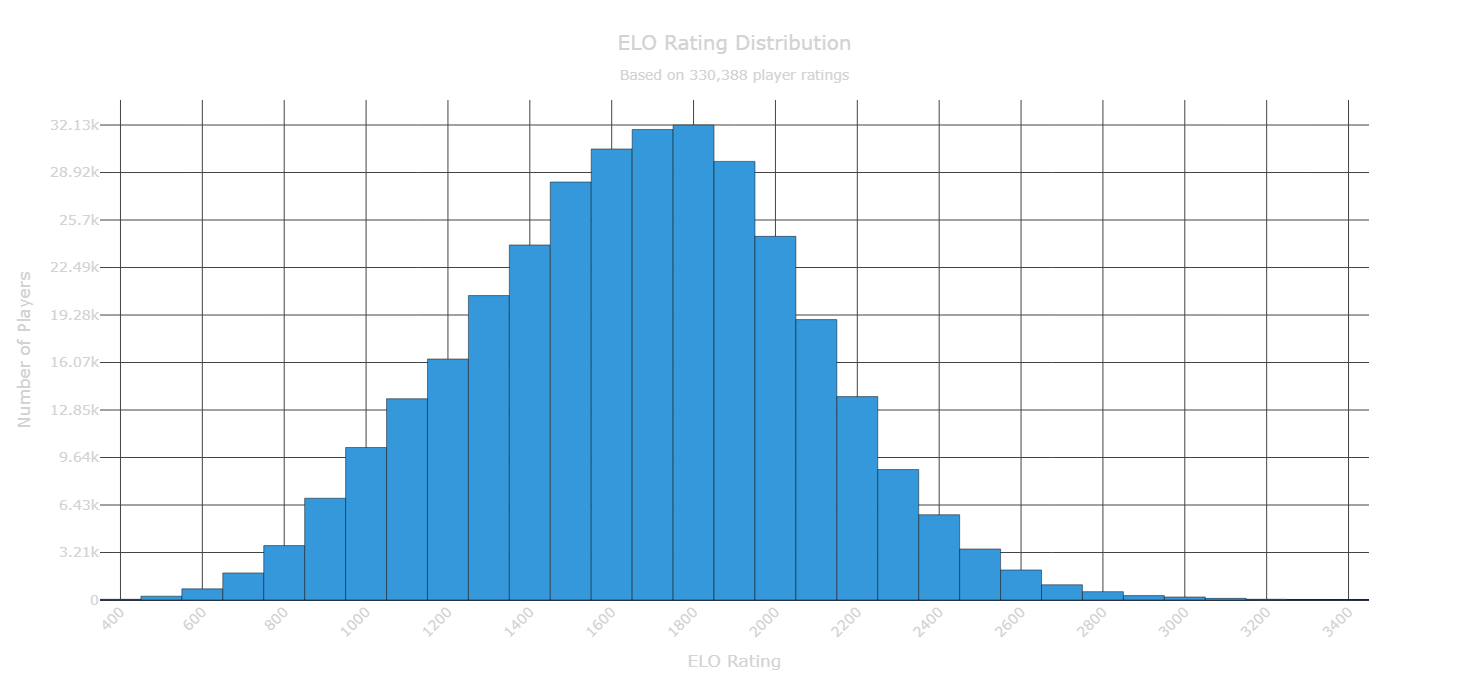


⏱️  Histogram created in 1.61 seconds
📊 Most common rating range: 1750–1850 (32,132 players)
📈 Peak represents 9.7% of all players
💾 Memory usage: 252 MB


251.75

In [7]:
# Add timing to see performance
import time
start_time = time.time()

print("--- Preparing histogram data ---")
check_memory()

min_elo_raw = ratings_pd['Elo'].min()
max_elo_raw = ratings_pd['Elo'].max()

min_elo = 0 if min_elo_raw - 50 < 0 else min_elo_raw - 50
max_elo = (max_elo_raw // 100 + 1) * 100
bins = list(range(int(min_elo), int(max_elo) + 100, 100))

print(f"Creating bins from {min_elo:.0f} to {max_elo:.0f} ELO")

ratings_pd['Rating_Bin'] = pd.cut(ratings_pd['Elo'], bins=bins, right=False, include_lowest=True)
binned_counts = ratings_pd.groupby('Rating_Bin', observed=True).size().reset_index(name='Count')
binned_counts = binned_counts[binned_counts['Count'] > 0]

# Add percentage calculation for better insights
total_ratings = binned_counts['Count'].sum()
binned_counts['Percentage'] = (binned_counts['Count'] / total_ratings * 100).round(2)

binned_counts['Bin_Midpoint'] = binned_counts['Rating_Bin'].apply(lambda x: x.mid)
binned_counts['Rating_Range'] = binned_counts['Rating_Bin'].apply(lambda x: f"{int(x.left)}–{int(x.right)}")

print(f"Created {len(binned_counts)} rating bins")
check_memory()

print("--- Generating Enhanced Interactive Histogram ---")

fig = go.Figure()
fig.add_trace(go.Bar(
    x=binned_counts['Bin_Midpoint'],
    y=binned_counts['Count'],
    width=100,
    marker_color='#3498db',
    customdata=list(zip(binned_counts['Rating_Range'], binned_counts['Percentage'])),
    hovertemplate='<b>Rating: %{customdata[0]}</b><br>Count: %{y:,}<br>Percentage: %{customdata[1]:.1f}%<extra></extra>'
))

fig.update_layout(
    width=1400,  
    height=700,
    title_text=f"ELO Rating Distribution<br><sub>Based on {total_ratings:,} player ratings</sub>",
    title_x=0.5,
    template="plotly_dark",
    xaxis_title="ELO Rating",
    yaxis_title="Number of Players",
    font=dict(size=14, color="lightgray"),
    xaxis=dict(
        showgrid=True, gridwidth=1, gridcolor='#444',
        dtick=200, 
        tickangle=-45
    ),
    yaxis=dict(
        showgrid=True, gridwidth=1, gridcolor='#444',
        dtick=(binned_counts['Count'].max() // 10) if binned_counts['Count'].max() > 10000 else 1000
    ),
    bargap=0.1,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    margin=dict(t=100, b=100, l=100, r=100),
)

fig.show()

# Performance and insights summary
end_time = time.time()
print(f"\n⏱️  Histogram created in {end_time - start_time:.2f} seconds")
print(f"📊 Most common rating range: {binned_counts.loc[binned_counts['Count'].idxmax(), 'Rating_Range']} ({binned_counts['Count'].max():,} players)")
print(f"📈 Peak represents {binned_counts['Percentage'].max():.1f}% of all players")

check_memory()

In [4]:
# --- Part 1: Load and Prepare the game-level DataFrame ---
print("--- Preparing the 'MovesArray' DataFrame ---")
check_memory()

print("Step 1: Cleaning move notation...")
df_cleaned_moves = df \
    .withColumn("CleanedMoves", regexp_replace(col("Moves"), r"\{.*?\}\s*", "")) \
    .withColumn("CleanedMoves", regexp_replace(col("CleanedMoves"), r"\d+\.+\s*", "")) \
    .withColumn("CleanedMoves", regexp_replace(col("CleanedMoves"), r"\s*(1-0|0-1|1/2-1/2)$", "")) \
    .withColumn("CleanedMoves", regexp_replace(col("CleanedMoves"), r"\s+", " ")) \
    .withColumn("CleanedMoves", trim(col("CleanedMoves")))

print("Step 2: Creating moves array...")
df_with_moves_array = df_cleaned_moves.withColumn("MovesArray", split(col("CleanedMoves"), " "))

check_memory()

# --- Part 2: Calculate all Checkmate Statistics ---
import time
start_time = time.time()
print("--- Calculating Checkmate Statistics (this will take a few minutes)... ---")

# Add data validation - check how many games have valid moves
total_games = df_with_moves_array.count()
games_with_moves = df_with_moves_array.filter(col("CleanedMoves") != "").count()
print(f"📊 Processing {total_games:,} games ({games_with_moves:,} have valid moves)")

df_with_last_move = df_with_moves_array.withColumn("LastMove", element_at(col("MovesArray"), -1))

# Filter for checkmate games with progress tracking
checkmate_games = df_with_last_move.filter(col("LastMove").like("%#"))
checkmate_count = checkmate_games.count()
print(f"🏁 Found {checkmate_count:,} games ending in checkmate ({checkmate_count/total_games*100:.2f}% of all games)")

check_memory()

# Extract checkmate details with better error handling
print("Analyzing checkmate patterns...")
checkmate_moves = checkmate_games.withColumn(
    "ToSquare", regexp_extract(col("LastMove"), r"([a-h][1-8])", 1)
).withColumn(
    "Piece",
    when(col("LastMove").like("O-O%"), "K")  # Castling checkmates
    .when(col("LastMove").rlike("^[KQRBN]"), substring(col("LastMove"), 1, 1))  # Piece moves
    .when(col("LastMove").rlike("^[a-h]"), "P")  # Pawn moves
    .otherwise("Unknown")
).filter(col("ToSquare") != "")  # Only valid square notations

# Check data quality
valid_checkmates = checkmate_moves.count()
invalid_checkmates = checkmate_count - valid_checkmates
if invalid_checkmates > 0:
    print(f"⚠️  Note: {invalid_checkmates:,} checkmate games had invalid notation and were excluded")

check_memory()

# --- Part 3: Create the final Pandas DataFrames for plotting ---
print("--- Preparing data for visualizations ---")

# Data for the summary bar chart with validation
checkmate_summary_pd = checkmate_moves.groupBy("Piece").count().orderBy(col("count").desc()).toPandas()

if checkmate_summary_pd.empty:
    print("❌ Error: No valid checkmate data found!")
else:
    print(f"✅ Found checkmates by: {', '.join(checkmate_summary_pd['Piece'].tolist())}")

# Data for all heatmaps
checkmate_heatmap_pd = checkmate_moves.groupBy("Piece", "ToSquare").count().toPandas()

print(f"📈 Created {len(checkmate_heatmap_pd)} unique piece-square combinations for heatmaps")

end_time = time.time()
print(f"\n⏱️  Checkmate analysis completed in {end_time - start_time:.1f} seconds")
print("🎯 Data preparation complete! Ready for plotting.")

check_memory()

# Clean up intermediate DataFrames to save memory
df_cleaned_moves = None
import gc
gc.collect()
print("🧹 Memory cleanup completed")
check_memory()

--- Preparing the 'MovesArray' DataFrame ---
💾 Memory usage: 219 MB
Step 1: Cleaning move notation...
Step 2: Creating moves array...
💾 Memory usage: 219 MB
--- Calculating Checkmate Statistics (this will take a few minutes)... ---


📊 Processing 3,297,234 games (3,290,591 have valid moves)


🏁 Found 814,680 games ending in checkmate (24.71% of all games)
💾 Memory usage: 72 MB
Analyzing checkmate patterns...


⚠️  Note: 34 checkmate games had invalid notation and were excluded
💾 Memory usage: 13 MB
--- Preparing data for visualizations ---


✅ Found checkmates by: Q, R, P, B, N, K


📈 Created 369 unique piece-square combinations for heatmaps

⏱️  Checkmate analysis completed in 661.9 seconds
🎯 Data preparation complete! Ready for plotting.
💾 Memory usage: 23 MB
🧹 Memory cleanup completed
💾 Memory usage: 127 MB


127.27734375

--- Creating Checkmate Analysis Bar Chart ---
💾 Memory usage: 129 MB


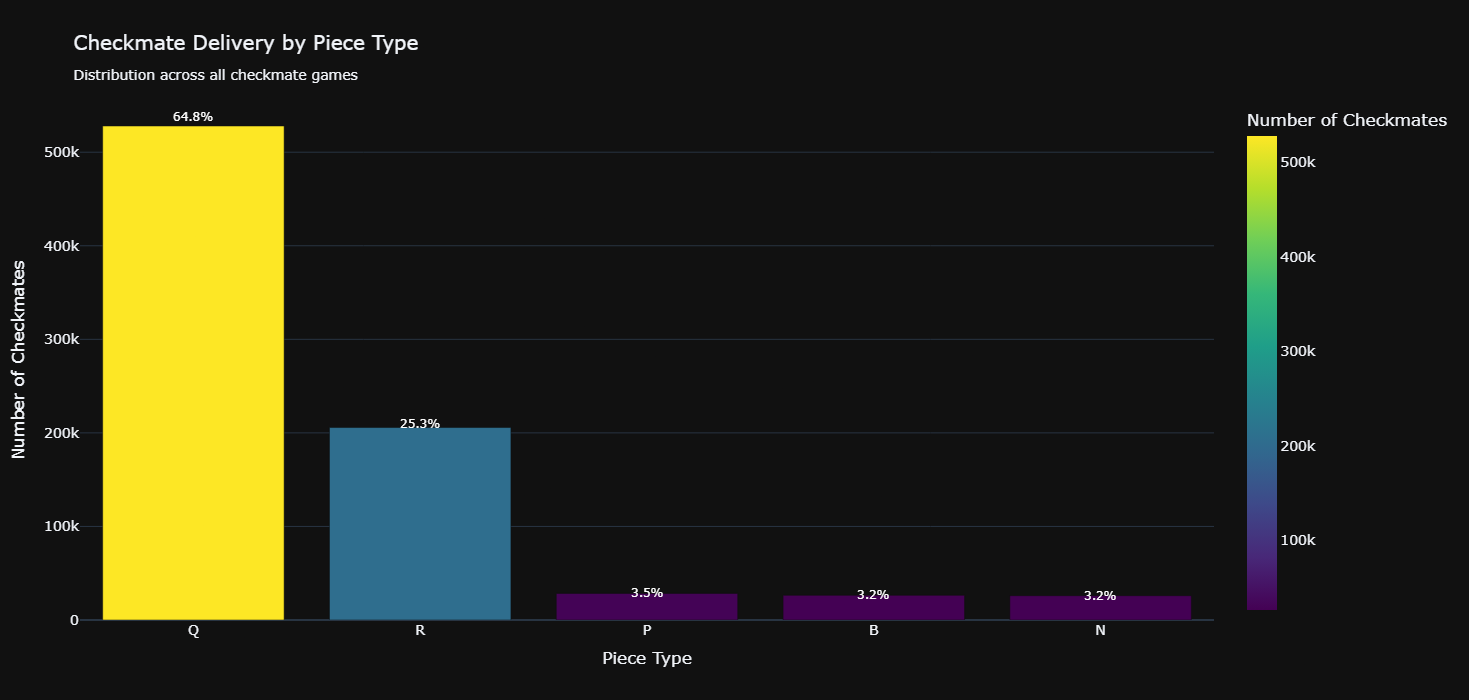

🏆 CHECKMATE ANALYSIS SUMMARY
Total checkmate games analyzed: 814,646

📊 Checkmate delivery breakdown:
   Queen   : 528,016 checkmates ( 64.8%)
   Rook    : 205,727 checkmates ( 25.3%)
   Pawn    : 28,351 checkmates (  3.5%)
   Bishop  : 26,347 checkmates (  3.2%)
   Knight  : 25,970 checkmates (  3.2%)
   King    :    235 checkmates (  0.0%)

💡 Key Insights:
   • Q (Queen) dominates with 64.8% of checkmates
   • King checkmates are extremely rare (0.03%) - excluded from chart for clarity
   • Top 3 pieces account for 93.6% of all checkmates
💾 Memory usage: 186 MB


186.15234375

In [5]:
print("--- Creating Checkmate Analysis Bar Chart ---")
check_memory()

# Prepare data excluding King checkmates for visibility
plot_data = checkmate_summary_pd[checkmate_summary_pd['Piece'] != 'K'].copy()

# Add percentage calculations for better insights
total_checkmates = checkmate_summary_pd['count'].sum()
plot_data['percentage'] = (plot_data['count'] / total_checkmates * 100).round(1)

# Create enhanced bar chart with percentages
fig = px.bar(
    plot_data,
    x="Piece",
    y="count",
    title="Checkmate Delivery by Piece Type<br><sub>Distribution across all checkmate games</sub>",
    template="plotly_dark",
    labels={'count': 'Number of Checkmates', 'Piece': 'Piece Type'},
    category_orders={"Piece": ['Q', 'R', 'P', 'B', 'N']},
    color='count',
    color_continuous_scale='Viridis'
)

# Add percentage annotations on bars
for i, row in plot_data.iterrows():
    fig.add_annotation(
        x=row['Piece'],
        y=row['count'] + (row['count'] * 0.02),
        text=f"{row['percentage']:.1f}%",
        showarrow=False,
        font=dict(color="white", size=12)
    )


fig.update_traces(
    hovertemplate='<b>%{x}</b><br>Checkmates: %{y:,}<br>Percentage: %{customdata:.1f}%<extra></extra>',
    customdata=plot_data['percentage']
)

fig.update_layout(
    width=1200, 
    height=700,
    showlegend=False,
    xaxis_title="Piece Type",
    yaxis_title="Number of Checkmates",
    font=dict(size=14),
)

fig.show()

king_row = checkmate_summary_pd[checkmate_summary_pd['Piece'] == 'K']
king_count = king_row['count'].iloc[0] if not king_row.empty else 0
king_percentage = (king_count / total_checkmates * 100) if king_count > 0 else 0

print("=" * 60)
print("🏆 CHECKMATE ANALYSIS SUMMARY")
print("=" * 60)
print(f"Total checkmate games analyzed: {total_checkmates:,}")
print(f"\n📊 Checkmate delivery breakdown:")

for _, row in checkmate_summary_pd.iterrows():
    piece_name = {
        'Q': 'Queen', 'R': 'Rook', 'B': 'Bishop', 
        'N': 'Knight', 'P': 'Pawn', 'K': 'King'
    }.get(row['Piece'], row['Piece'])
    
    percentage = (row['count'] / total_checkmates * 100)
    print(f"   {piece_name:8}: {row['count']:6,} checkmates ({percentage:5.1f}%)")

print(f"\n💡 Key Insights:")
print(f"   • {plot_data.iloc[0]['Piece']} (Queen) dominates with {plot_data.iloc[0]['percentage']:.1f}% of checkmates")
print(f"   • King checkmates are extremely rare ({king_percentage:.2f}%) - excluded from chart for clarity")
print(f"   • Top 3 pieces account for {plot_data.head(3)['percentage'].sum():.1f}% of all checkmates")

print("=" * 60)

check_memory()

--- Preparing Overall Checkmate Heatmap Data ---
--- Generating enhanced heatmap for: Overall Heatmap of Checkmating Squares ---
💾 Memory usage: 187 MB
📊 Analyzing 814,646 checkmates by Any
🎯 Hottest square: g2 (6.3% - 51,719.0 checkmates)
📍 Active squares: 38/64 squares show significant checkmate activity


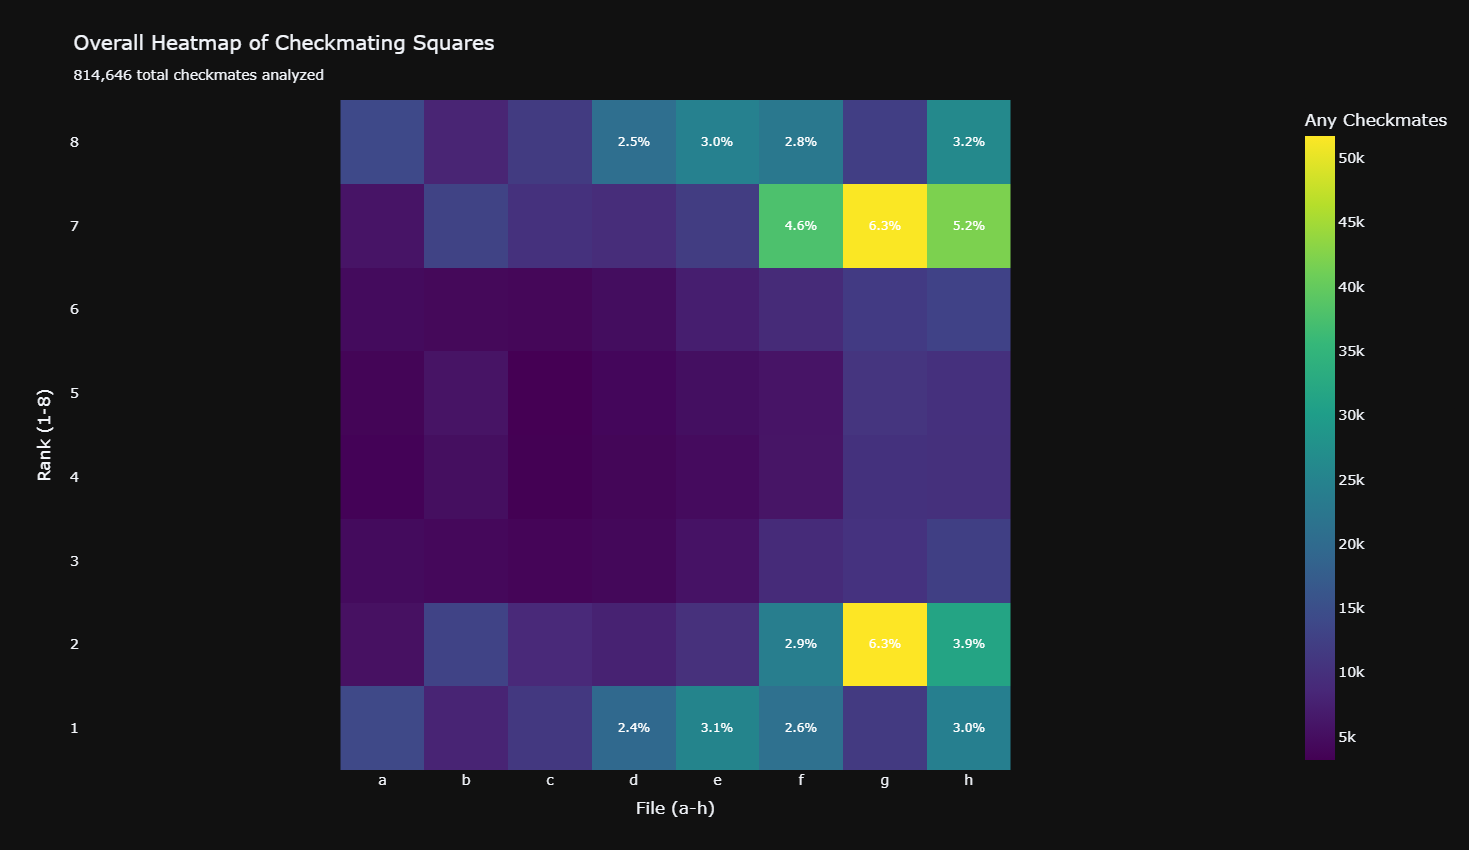

💾 Memory usage: 189 MB


In [6]:
def plot_enhanced_heatmap(data_pd, piece_symbol, title):
    print(f"--- Generating enhanced heatmap for: {title} ---")
    check_memory()
    
    # Data validation and preparation
    piece_data = data_pd[data_pd['Piece'] == piece_symbol].copy()
    
    if piece_data.empty:
        print(f"⚠️  No data found for piece '{piece_symbol}' - skipping heatmap")
        return
    
    total_piece_checkmates = piece_data['count'].sum()
    print(f"📊 Analyzing {total_piece_checkmates:,} checkmates by {piece_symbol}")
    
    if total_piece_checkmates > 0:
        piece_data['percentage'] = (piece_data['count'] / total_piece_checkmates) * 100
    else:
        piece_data['percentage'] = 0
    
    # Extract rank and file with validation
    piece_data['rank'] = piece_data['ToSquare'].str[1]
    piece_data['file'] = piece_data['ToSquare'].str[0]
    
    # Create pivot tables
    heatmap_grid = piece_data.pivot_table(index='rank', columns='file', values='count', fill_value=0)
    percentage_grid = piece_data.pivot_table(index='rank', columns='file', values='percentage', fill_value=0)
    
    # Ensure proper board orientation (rank 8 at top, rank 1 at bottom)
    files_order = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
    ranks_order = ['8', '7', '6', '5', '4', '3', '2', '1'] 
    
    heatmap_grid = heatmap_grid.reindex(index=ranks_order, columns=files_order, fill_value=0)
    percentage_grid = percentage_grid.reindex(index=ranks_order, columns=files_order, fill_value=0)
    
    # Create annotations (show percentages on squares with significant activity)
    annot_text = percentage_grid.map(lambda x: f"{x:.1f}%" if x > 2.0 else "").values  # Only show if >2%
    custom_data = np.dstack((heatmap_grid.values, percentage_grid.values))
    
    # Enhanced color scale based on piece type
    color_scales = {
        'Q': 'Reds',     # Queen - Red (most powerful)
        'R': 'Blues',    # Rook - Blue 
        'B': 'Greens',   # Bishop - Green
        'N': 'Oranges',  # Knight - Orange
        'P': 'Purples',  # Pawn - Purple
        'K': 'Greys',    # King - Grey (rare)
        'Any': 'Viridis' # Overall - Viridis
    }
    color_scale = color_scales.get(piece_symbol, 'Reds')
    
    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=heatmap_grid.values,
        x=heatmap_grid.columns,
        y=heatmap_grid.index,
        colorscale=color_scale,
        customdata=custom_data,
        hovertemplate='<b>Square: %{x}%{y}</b><br>Count: %{customdata[0]:,}<br>Percentage: %{customdata[1]:.2f}%<extra></extra>',
        text=annot_text,
        texttemplate="%{text}",
        textfont={"size": 12, "color": "white"},
        colorbar=dict(title=f"{piece_symbol} Checkmates")
    ))
    
    piece_names = {
        'Q': 'Queen', 'R': 'Rook', 'B': 'Bishop', 
        'N': 'Knight', 'P': 'Pawn', 'K': 'King', 'Any': 'All Pieces'
    }
    piece_name = piece_names.get(piece_symbol, piece_symbol)
    
    fig.update_layout(
        title=f"{title}<br><sub>{total_piece_checkmates:,} total checkmates analyzed</sub>",
        width=850, height=850,
        template="plotly_dark",
        xaxis_title="File (a-h)",
        yaxis_title="Rank (1-8)",
        xaxis=dict(showgrid=False, side="bottom"),
        yaxis=dict(showgrid=False, autorange="reversed"),
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    
    # Find and display key insights
    if not percentage_grid.empty:
        # Find the most active square
        max_idx = np.unravel_index(percentage_grid.values.argmax(), percentage_grid.values.shape)
        hottest_rank = percentage_grid.index[max_idx[0]]
        hottest_file = percentage_grid.columns[max_idx[1]]
        hottest_square = f"{hottest_file}{hottest_rank}"
        hottest_percentage = percentage_grid.iloc[max_idx]
        hottest_count = heatmap_grid.iloc[max_idx]
        
        print(f"🎯 Hottest square: {hottest_square} ({hottest_percentage:.1f}% - {hottest_count:,} checkmates)")
        
        # Count active squares (>1% activity)
        active_squares = (percentage_grid > 1.0).sum().sum()
        print(f"📍 Active squares: {active_squares}/64 squares show significant checkmate activity")
    
    fig.show()
    check_memory()

# Create the summary data for the overall heatmap
print("--- Preparing Overall Checkmate Heatmap Data ---")
overall_heatmap_pd = checkmate_heatmap_pd.groupby('ToSquare')['count'].sum().reset_index()
overall_heatmap_pd['Piece'] = 'Any'

plot_enhanced_heatmap(overall_heatmap_pd, 'Any', 'Overall Heatmap of Checkmating Squares')


🎯 GENERATING INDIVIDUAL PIECE HEATMAPS

🔄 Processing K heatmap...
--- Generating enhanced heatmap for: Squares where a King Delivers Checkmate ---
💾 Memory usage: 189 MB
📊 Analyzing 235 checkmates by K
🎯 Hottest square: f2 (8.9% - 21.0 checkmates)
📍 Active squares: 28/64 squares show significant checkmate activity


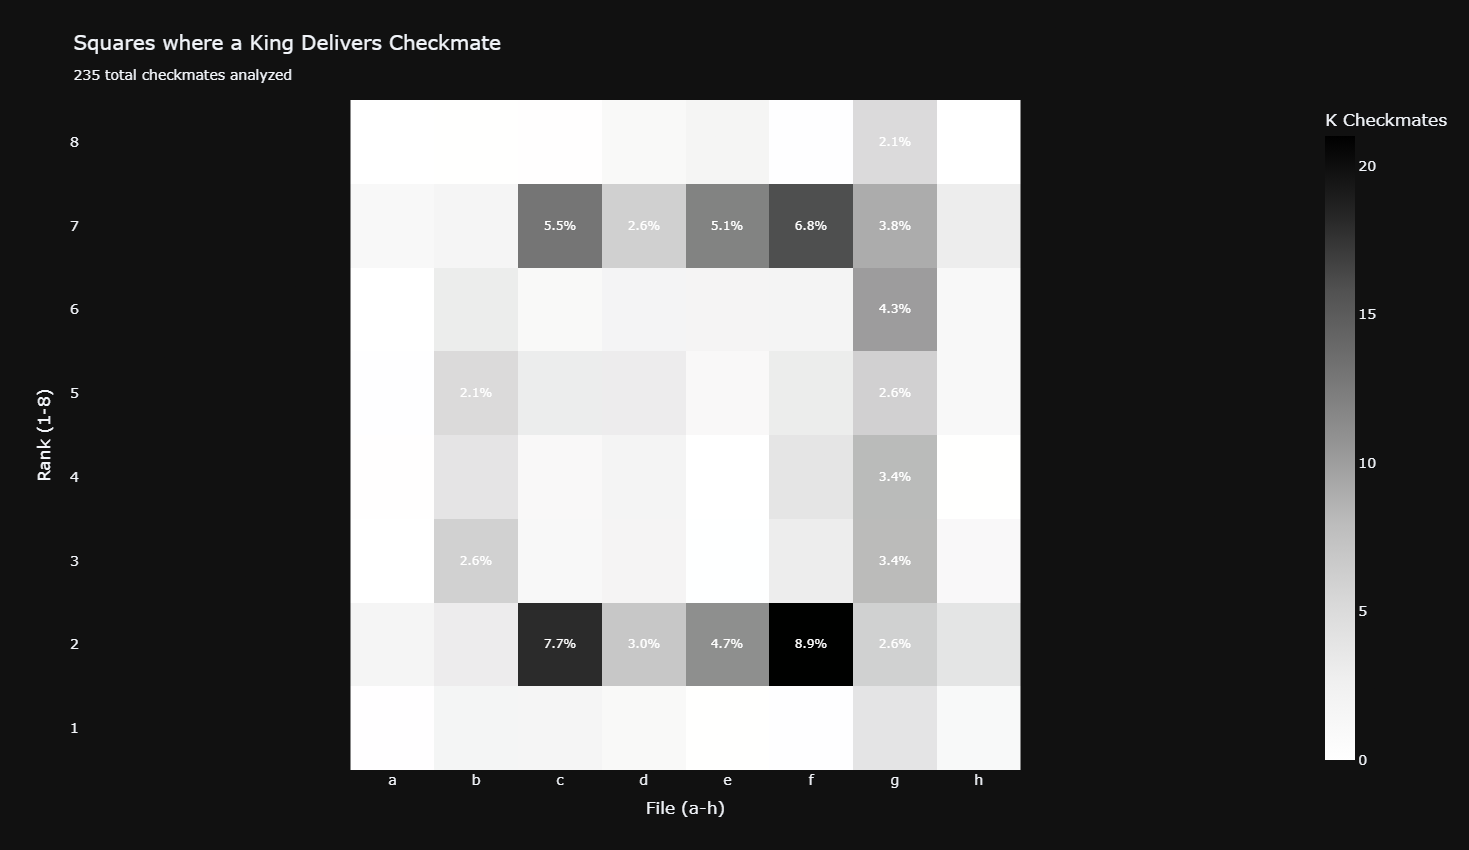

💾 Memory usage: 189 MB

🔄 Processing Q heatmap...
--- Generating enhanced heatmap for: Squares where a Queen Delivers Checkmate ---
💾 Memory usage: 189 MB
📊 Analyzing 528,016 checkmates by Q
🎯 Hottest square: g2 (9.1% - 48,173.0 checkmates)
📍 Active squares: 34/64 squares show significant checkmate activity


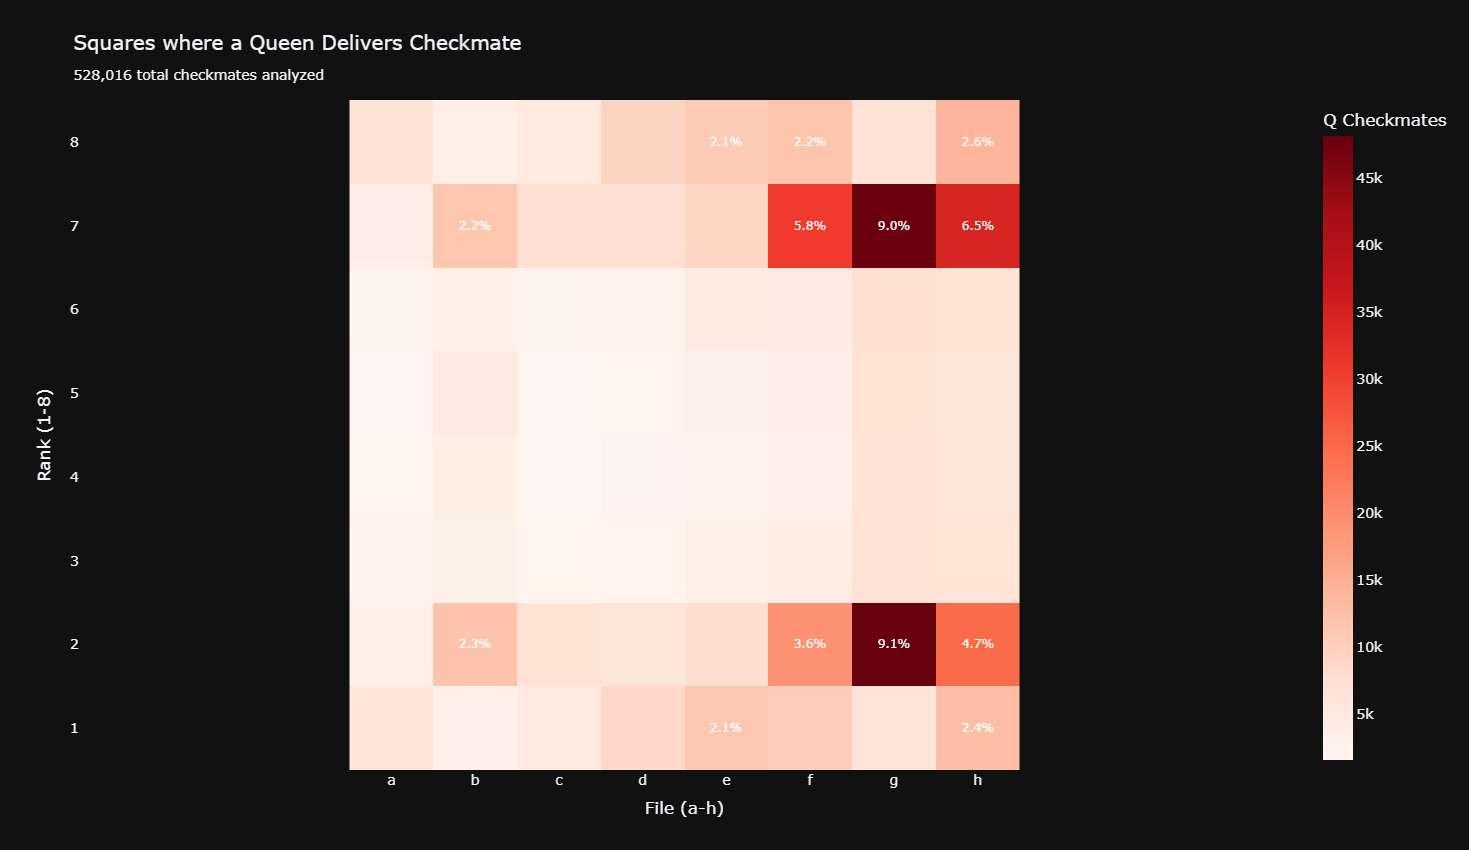

💾 Memory usage: 190 MB

🔄 Processing R heatmap...
--- Generating enhanced heatmap for: Squares where a Rook Delivers Checkmate ---
💾 Memory usage: 190 MB
📊 Analyzing 205,727 checkmates by R
🎯 Hottest square: e1 (6.2% - 12,788.0 checkmates)
📍 Active squares: 28/64 squares show significant checkmate activity


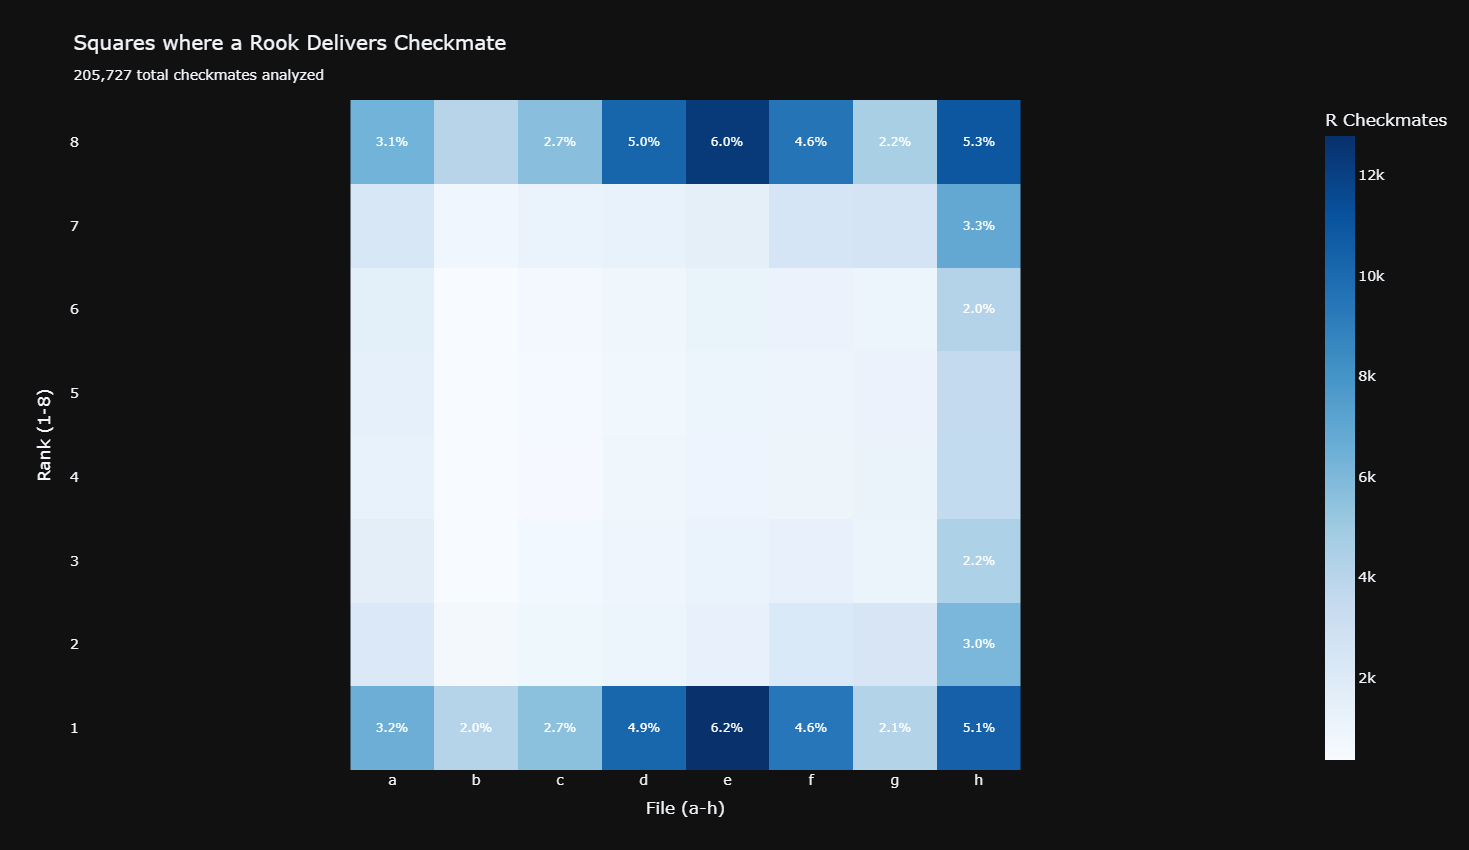

💾 Memory usage: 190 MB

🔄 Processing B heatmap...
--- Generating enhanced heatmap for: Squares where a Bishop Delivers Checkmate ---
💾 Memory usage: 190 MB
📊 Analyzing 26,347 checkmates by B
🎯 Hottest square: f6 (6.1% - 1,617.0 checkmates)
📍 Active squares: 34/64 squares show significant checkmate activity


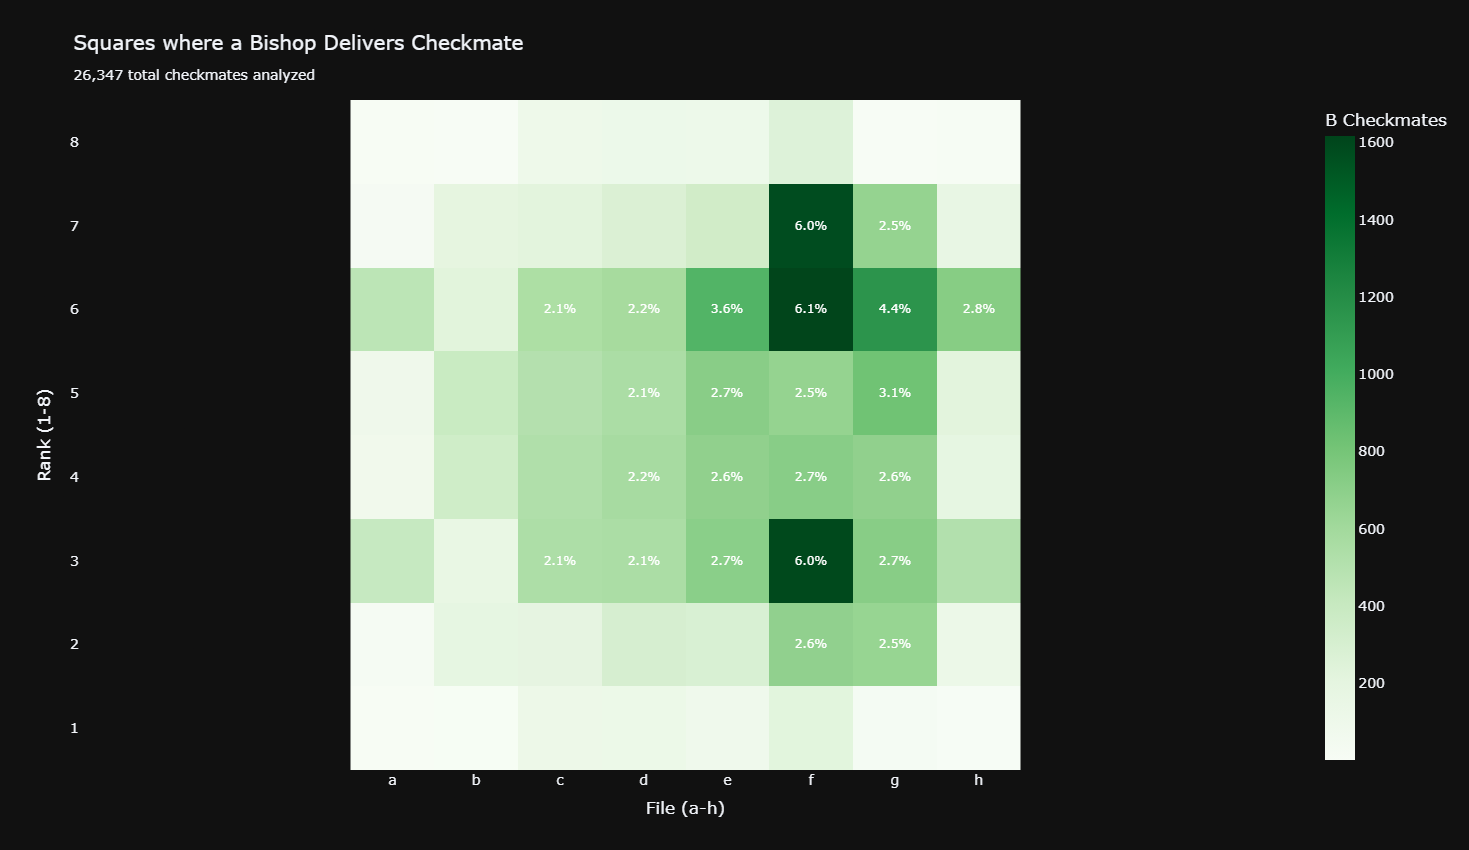

💾 Memory usage: 190 MB

🔄 Processing N heatmap...
--- Generating enhanced heatmap for: Squares where a Knight Delivers Checkmate ---
💾 Memory usage: 190 MB
📊 Analyzing 25,970 checkmates by N
🎯 Hottest square: f7 (9.6% - 2,487.0 checkmates)
📍 Active squares: 33/64 squares show significant checkmate activity


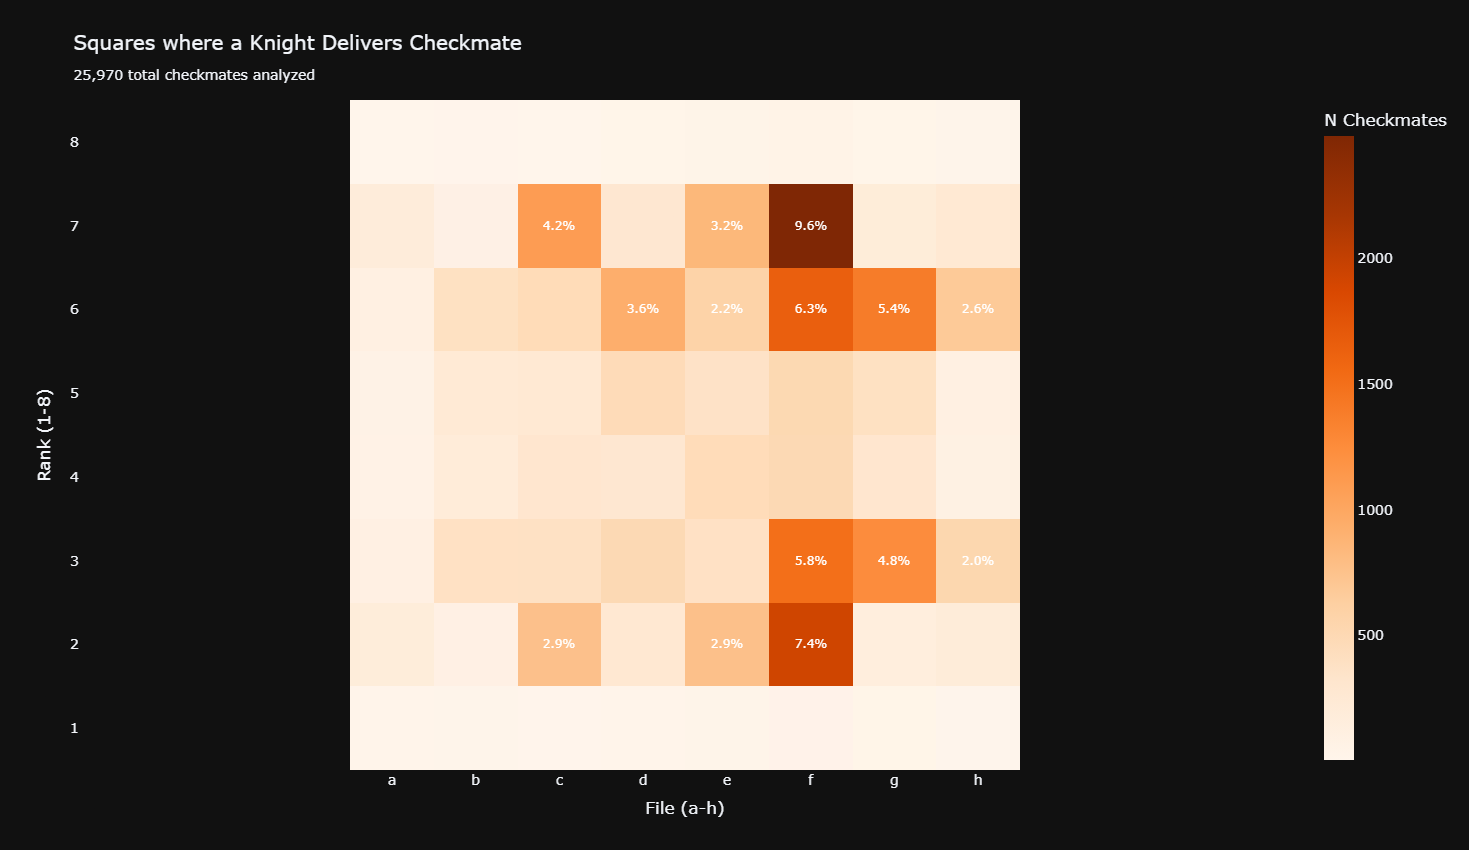

💾 Memory usage: 190 MB

🔄 Processing P heatmap...
--- Generating enhanced heatmap for: Squares where a Pawn Delivers Checkmate ---
💾 Memory usage: 190 MB
📊 Analyzing 28,351 checkmates by P
🎯 Hottest square: g5 (4.6% - 1,299.0 checkmates)
📍 Active squares: 32/64 squares show significant checkmate activity


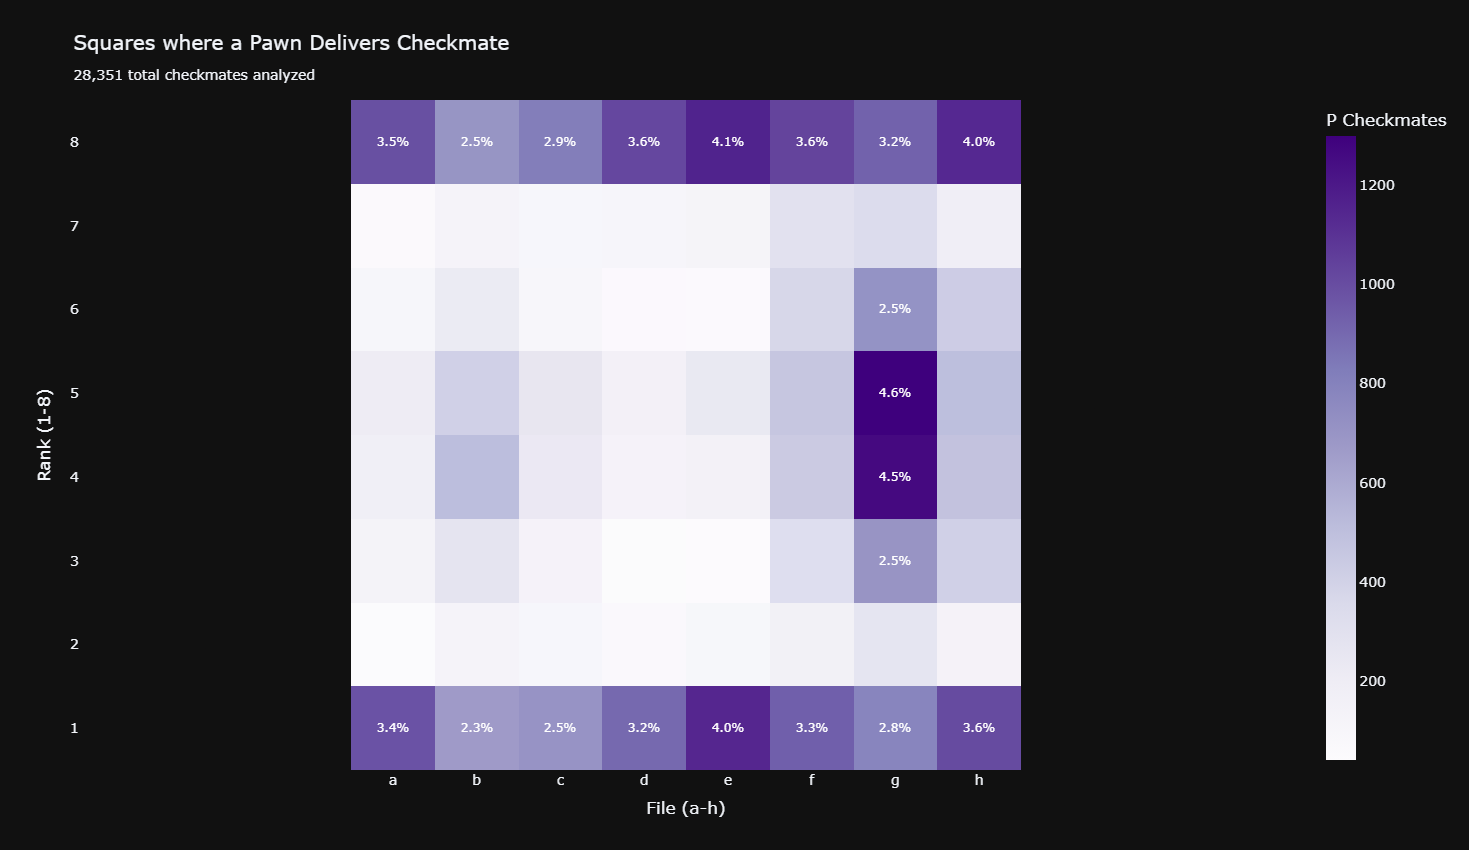

💾 Memory usage: 190 MB

✅ All individual piece heatmaps completed!


In [7]:
# Generate heatmaps for each individual piece
print("\n" + "="*60)
print("🎯 GENERATING INDIVIDUAL PIECE HEATMAPS")
print("="*60)

# List of pieces to analyze (in order of checkmate frequency)
pieces_to_plot = [
    ('K', 'Squares where a King Delivers Checkmate'),
    ('Q', 'Squares where a Queen Delivers Checkmate'), 
    ('R', 'Squares where a Rook Delivers Checkmate'),
    ('B', 'Squares where a Bishop Delivers Checkmate'),
    ('N', 'Squares where a Knight Delivers Checkmate'),
    ('P', 'Squares where a Pawn Delivers Checkmate')
]

# Generate each heatmap
for piece_symbol, title in pieces_to_plot:
    print(f"\n🔄 Processing {piece_symbol} heatmap...")
    plot_enhanced_heatmap(checkmate_heatmap_pd, piece_symbol, title)
    
    # Add small delay and cleanup between heavy plots
    import time
    time.sleep(0.5)  # Brief pause to prevent overwhelming the system

print("\n✅ All individual piece heatmaps completed!")
print("="*60)

In [15]:
#######################################################################################################################################################################################

In [16]:
#Note:- If the below code gives any memory error or spark crashes try restarting kernel and runinng following cells in new different notebook

In [16]:
print("--- Loading the saved player ratings CSV ---")
check_memory()

try:
    csv_file_path = glob.glob("player_analysis_results/player_ratings.csv/*.csv")[0]
    ratings_pd = pd.read_csv(csv_file_path)
    print(f"✅ Loaded {len(ratings_pd):,} total player entries from {csv_file_path}")
    
    # Simple data quality check
    print(f"📊 Columns: {list(ratings_pd.columns)}")
    
    # Show coverage for each rating type
    for col in ['classical_rating', 'blitz_rating', 'bullet_rating']:
        if col in ratings_pd.columns:
            non_null_count = ratings_pd[col].notna().sum()
            print(f"   {col}: {non_null_count:,} players have this rating")
    
except IndexError:
    print("❌ ERROR: Could not find the CSV file. Did the previous notebook run successfully?")
    ratings_pd = None
except Exception as e:
    print(f"❌ ERROR: Could not load CSV file: {e}")
    ratings_pd = None

check_memory()

--- Loading the saved player ratings CSV ---
💾 Memory usage: 186 MB
✅ Loaded 515,954 total player entries from player_analysis_results/player_ratings.csv/part-00000-af220711-f758-43e9-a48e-aa51f606c6c3-c000.csv
📊 Columns: ['Player', 'blitz_rating', 'bullet_rating', 'classical_rating']
   classical_rating: 14,523 players have this rating
   blitz_rating: 364,356 players have this rating
   bullet_rating: 187,380 players have this rating
💾 Memory usage: 247 MB


247.30078125


--- Generating 'Classical vs. Blitz Rating Correlation' ---
📊 Found 3,122 players with both ratings.
💾 Memory usage: 264 MB


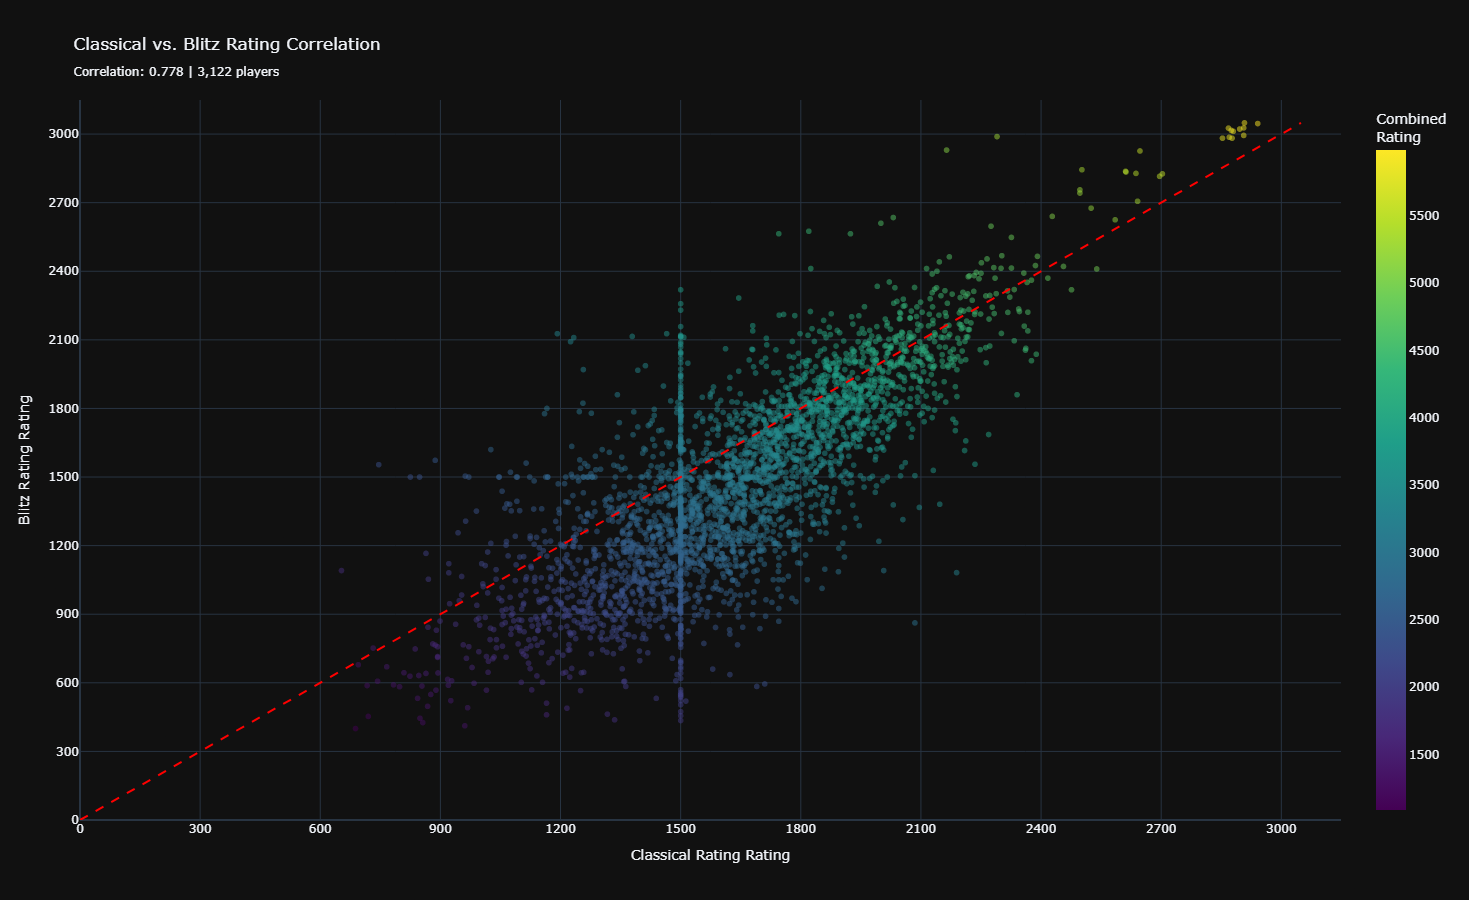

🔍 Statistical Analysis:
   Correlation coefficient: 0.778
   R-squared: 0.606
   Players above diagonal: 768
   Players below diagonal: 2,321
   Biggest rating difference: GRIMREAP2R (1223 points)

--- Generating 'Bullet vs. Blitz Rating Correlation' ---
📊 Found 46,110 players with both ratings.
💾 Memory usage: 264 MB


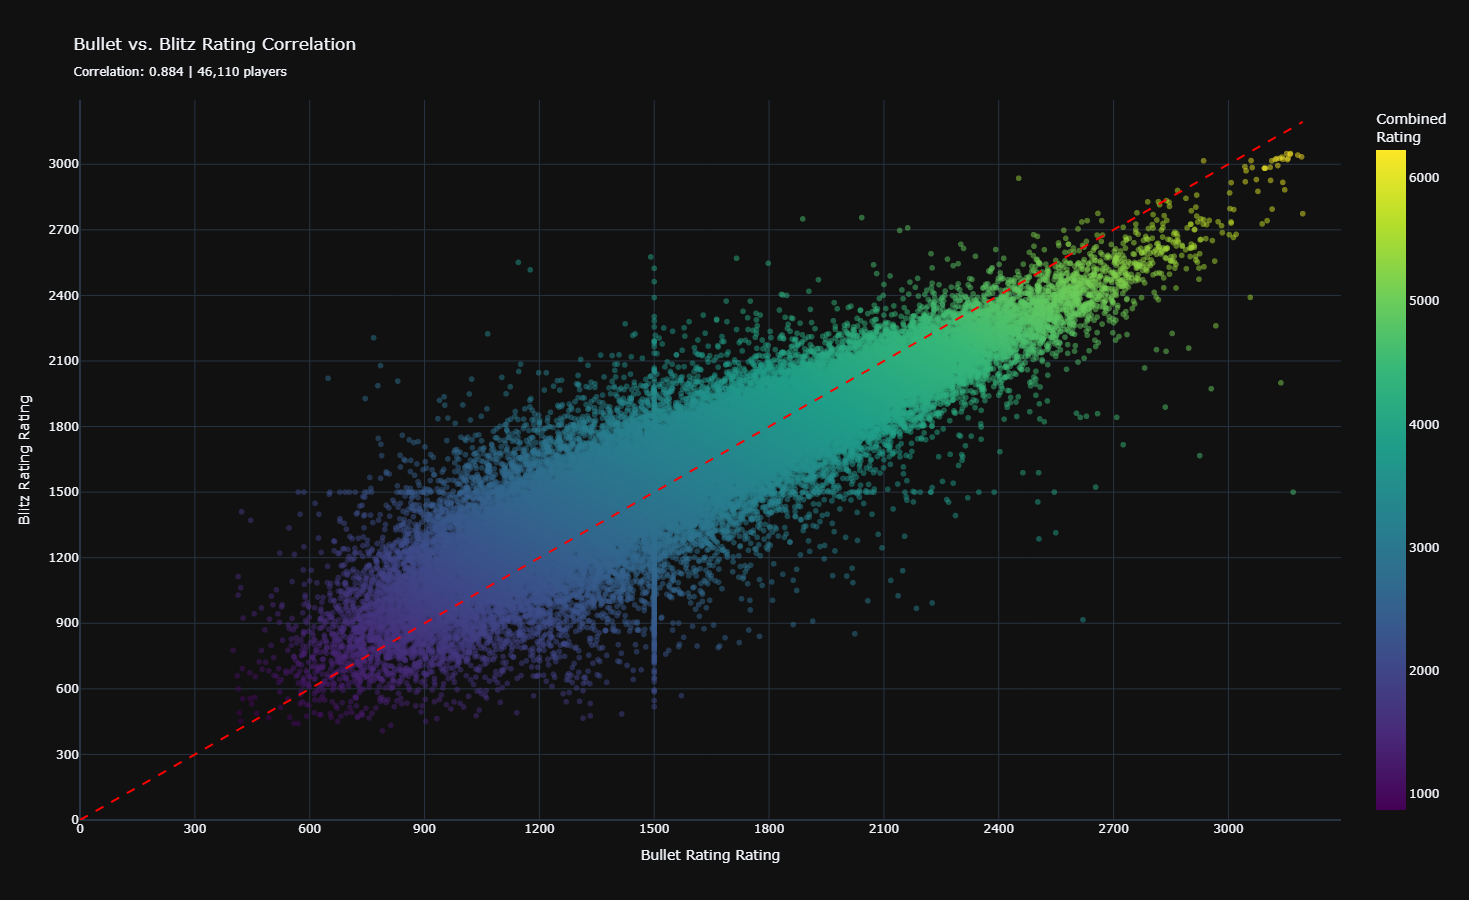

🔍 Statistical Analysis:
   Correlation coefficient: 0.884
   R-squared: 0.782
   Players above diagonal: 23,911
   Players below diagonal: 21,990
   Biggest rating difference: marcosryann (1704 points)

--- Generating 'Classical vs. Bullet Rating Correlation' ---
📊 Found 2,219 players with both ratings.
💾 Memory usage: 265 MB


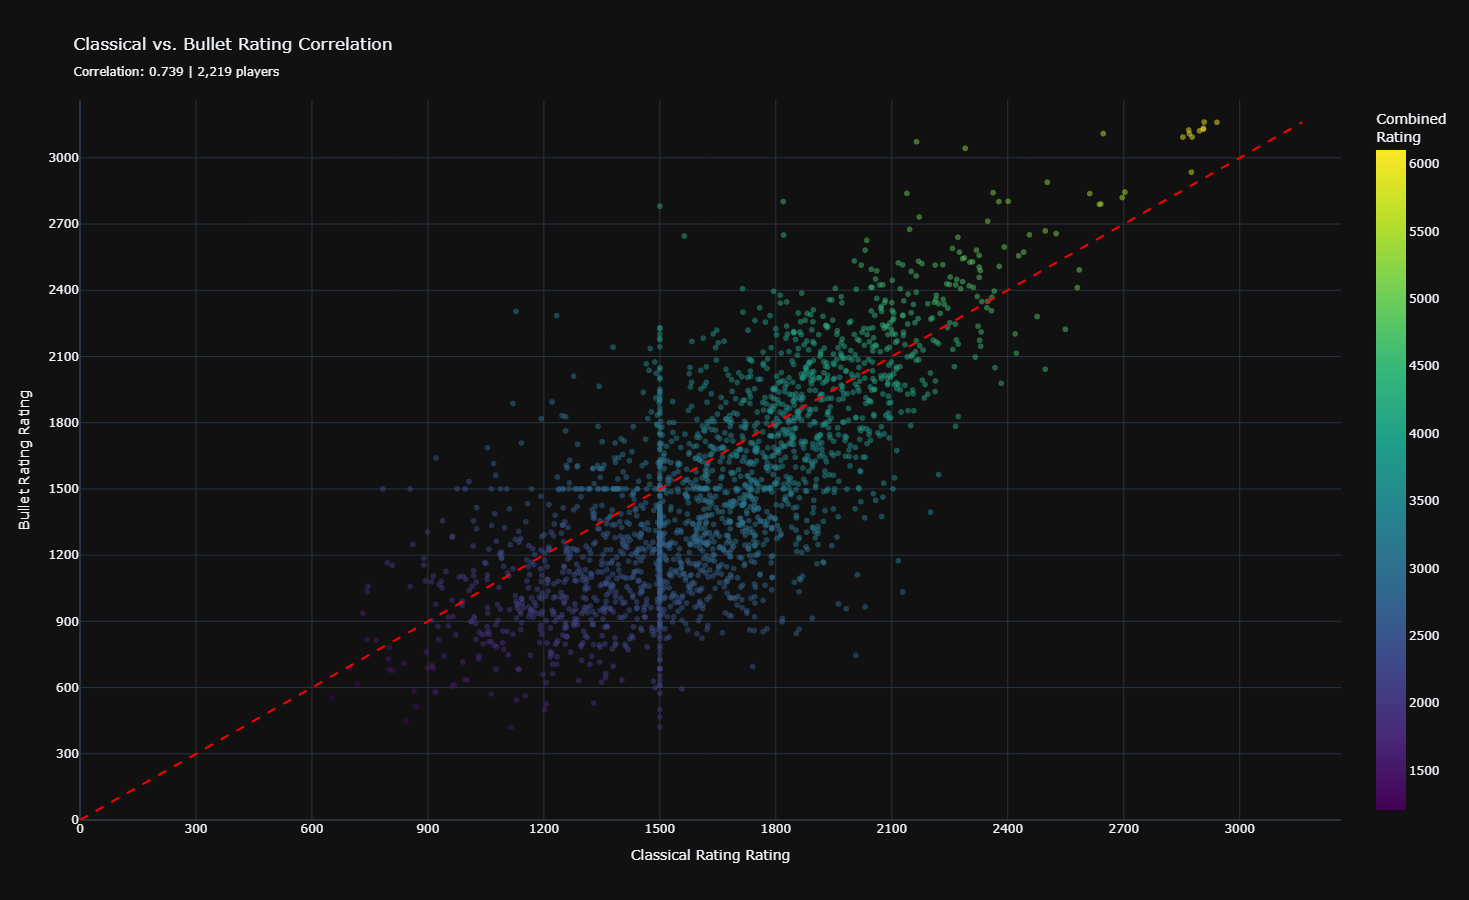

🔍 Statistical Analysis:
   Correlation coefficient: 0.739
   R-squared: 0.547
   Players above diagonal: 743
   Players below diagonal: 1,437
   Biggest rating difference: seiryu0 (1281 points)


In [19]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import glob

def create_enhanced_rating_scatterplot(data_pd, x_col, y_col, title):
    
    if data_pd is None or data_pd.empty:
        print(f"⚠️  No data available for {title}")
        return
    
    # Filter for players who have ratings in both modes
    plot_data = data_pd.dropna(subset=[x_col, y_col])
    print(f"\n--- Generating '{title}' ---")
    print(f"📊 Found {len(plot_data):,} players with both ratings.")
    check_memory()
    
    if plot_data.empty:
        print(f"❌ No players found with both {x_col} and {y_col}")
        return
    
    # Calculate correlation and other insights
    correlation = plot_data[x_col].corr(plot_data[y_col])
    
    # Find max rating for axis scaling
    max_x = plot_data[x_col].max()
    max_y = plot_data[y_col].max()
    max_rating = max_x if max_x > max_y else max_y
    axis_range = [0, max_rating + 100]
    
    # Create scatter plot with enhanced styling
    fig = px.scatter(
        data_frame=plot_data, 
        x=x_col, 
        y=y_col,
        template="plotly_dark",
        opacity=0.5,
        hover_name="Player",
        color=plot_data[x_col] + plot_data[y_col],  # Color by total rating
        color_continuous_scale="Viridis",
        title=f"{title}<br><sub>Correlation: {correlation:.3f} | {len(plot_data):,} players</sub>"
    )
    
    # Add diagonal reference line (perfect correlation)
    fig.add_shape(type="line", x0=0, y0=0, x1=max_rating, y1=max_rating,
                  line=dict(color="red", width=2, dash="dash"))
    
    # Add correlation trend line
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(plot_data[x_col], plot_data[y_col])
    line_x = [plot_data[x_col].min(), plot_data[x_col].max()]
    line_y = [slope * x + intercept for x in line_x]
    
    fig.update_layout(
    width=1000, height=900,
    xaxis=dict(range=axis_range, dtick=300, title=f"{x_col.replace('_', ' ').title()}"),
    yaxis=dict(range=axis_range, dtick=300, title=f"{y_col.replace('_', ' ').title()}"),
    coloraxis_colorbar=dict(title="Combined<br>Rating"),
    font=dict(size=12),
    legend=dict(
        x=0.02,  # Left side (0 = far left, 1 = far right)
        y=0.98,  # Top (0 = bottom, 1 = top)
        bgcolor="rgba(0,0,0,0.5)",  # Semi-transparent background
        bordercolor="white",
        borderwidth=1
    )
)
    
    fig.update_layout(
        width=1000, height=900,
        xaxis=dict(range=axis_range, dtick=300, title=f"{x_col.replace('_', ' ').title()}"),
        yaxis=dict(range=axis_range, dtick=300, title=f"{y_col.replace('_', ' ').title()}"),
        coloraxis_colorbar=dict(title="Combined<br>Rating"),
        font=dict(size=12)
    )
    
    fig.show()
    
    # Print detailed analysis
    print(f"🔍 Statistical Analysis:")
    print(f"   Correlation coefficient: {correlation:.3f}")
    print(f"   R-squared: {r_value**2:.3f}")
    print(f"   Players above diagonal: {len(plot_data[plot_data[y_col] > plot_data[x_col]]):,}")
    print(f"   Players below diagonal: {len(plot_data[plot_data[y_col] < plot_data[x_col]]):,}")
    
    # Identify interesting players
    if 'Player' in plot_data.columns:
        # Biggest rating differences
        plot_data_with_diff = plot_data.copy()
        plot_data_with_diff['diff'] = abs(plot_data_with_diff[x_col] - plot_data_with_diff[y_col])
        biggest_diff = plot_data_with_diff.loc[plot_data_with_diff['diff'].idxmax()]
        print(f"   Biggest rating difference: {biggest_diff['Player']} ({biggest_diff['diff']:.0f} points)")

# Generate the enhanced scatter plots
if ratings_pd is not None and not ratings_pd.empty:
    create_enhanced_rating_scatterplot(ratings_pd, 'classical_rating', 'blitz_rating', 
                                     'Classical vs. Blitz Rating Correlation')
    create_enhanced_rating_scatterplot(ratings_pd, 'bullet_rating', 'blitz_rating', 
                                     'Bullet vs. Blitz Rating Correlation')
    create_enhanced_rating_scatterplot(ratings_pd, 'classical_rating', 'bullet_rating', 
                                     'Classical vs. Bullet Rating Correlation')
else:
    print("⚠️  Skipping scatter plots - no player rating data available")

GAME METADATA ANALYSIS
💾 Memory usage: 264 MB
--- Distribution of Event Types ---


[Stage 25:=========================================>              (39 + 8) / 53]

Total games analyzed: 3,297,234
Showing 4 most common event types (1 rare types excluded)


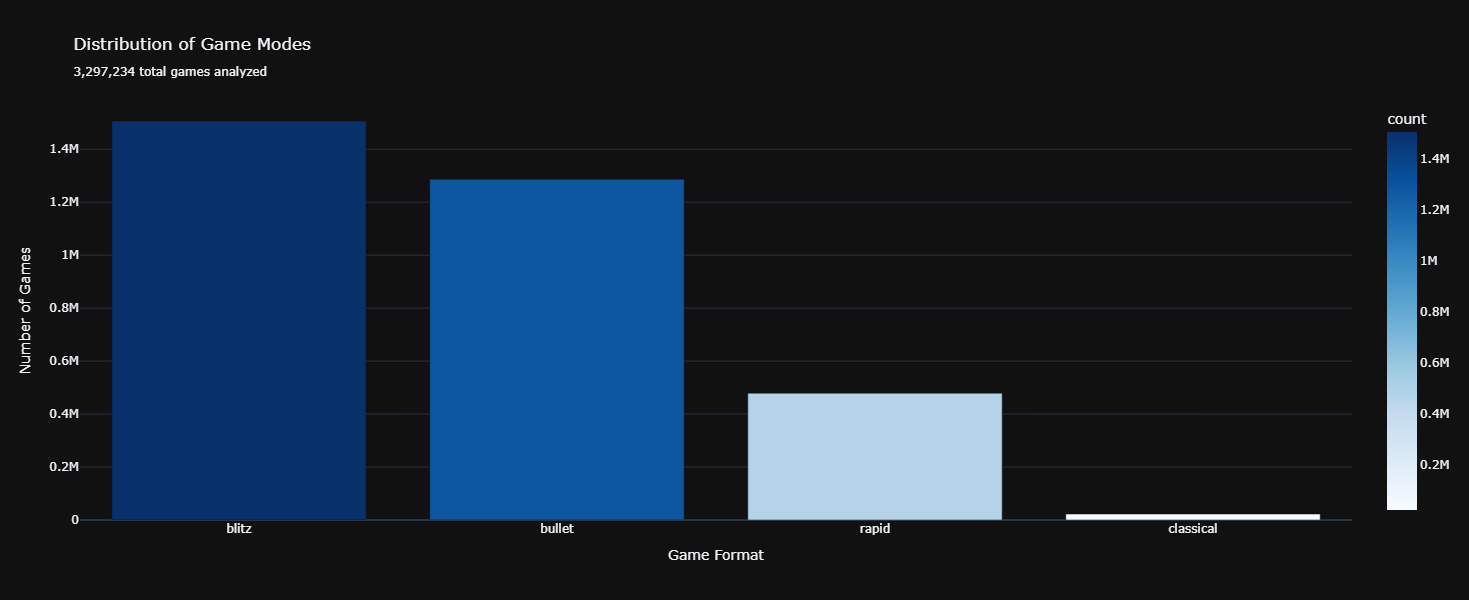

Excluded rare formats (2,449 games, 0.07% of total):
  - correspondence: 2,449 games (0.07%)
Time: 2.7s

--- Distribution of Game Results ---


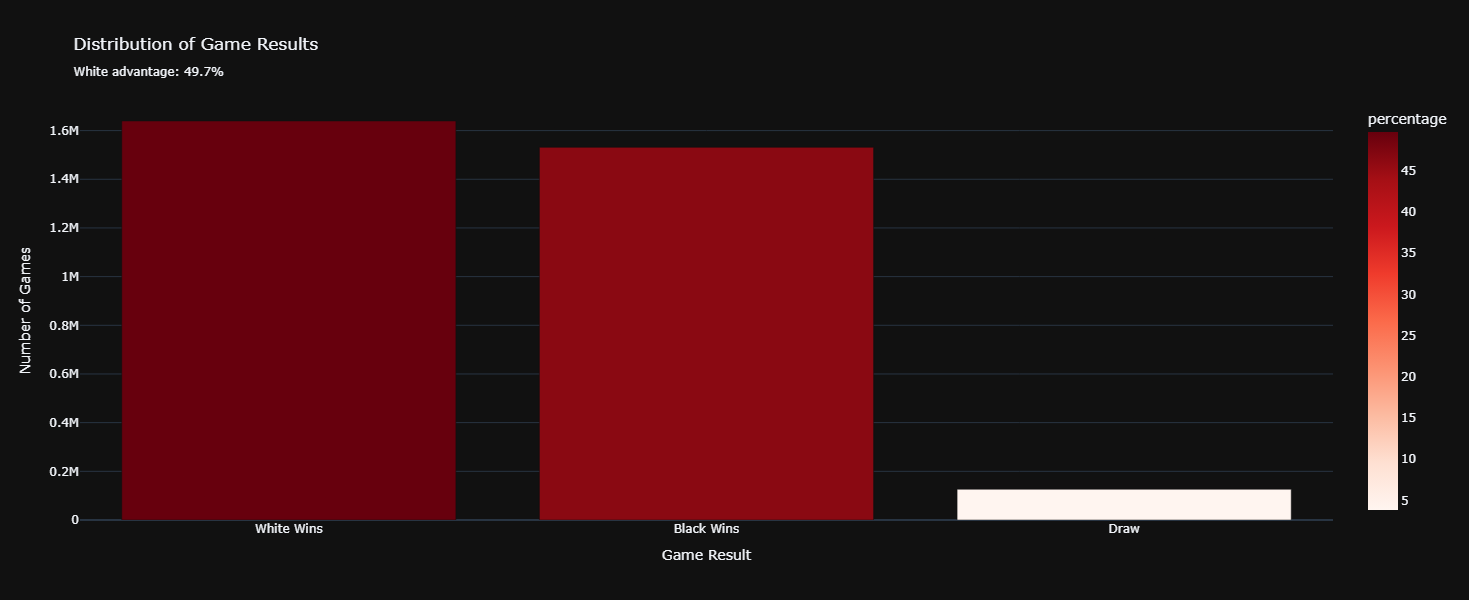

Chess Statistics:
  White advantage: 3.3 percentage points
  Decisive games: 96.2% (non-draws)
Excluded rare results:
  - *: 241 games
Time: 1.5s

--- Distribution of Termination Types ---


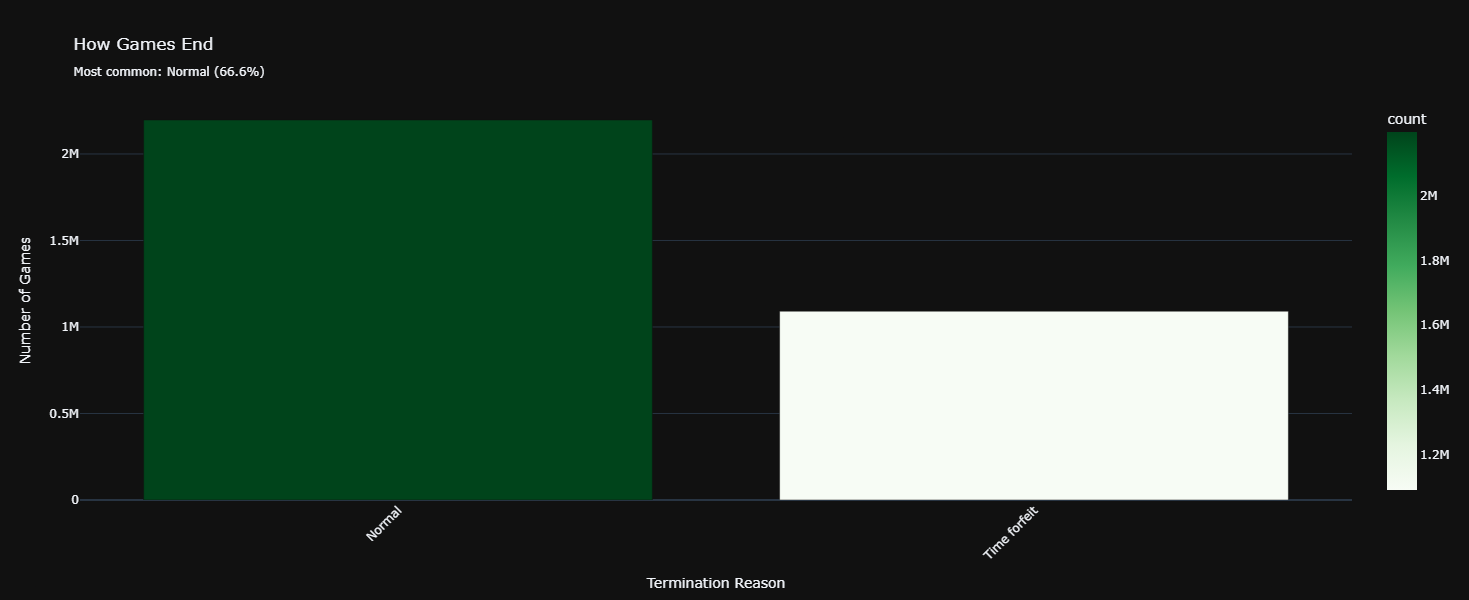

Top 3 termination types:
  1. Normal: 2,196,360 games (66.6%)
  2. Time forfeit: 1,091,522 games (33.1%)
Excluded rare terminations (9,352 games):
  - Abandoned: 9,018 games
  - Unterminated: 241 games
  - Rules infraction: 93 games
Time: 1.7s
💾 Memory usage: 264 MB


264.015625

In [20]:
import plotly.express as px
import pandas as pd
from pyspark.sql.functions import col
import time

print("=" * 60)
print("GAME METADATA ANALYSIS")
print("=" * 60)
check_memory()

# ===================================================================
# --- Plot 1: Event Types ---
# ===================================================================
print("--- Distribution of Event Types ---")
start_time = time.time()

event_type_pd = df.groupBy("EventType").count().orderBy("count", ascending=False).toPandas()

# Enhanced analysis with percentages
total_events = event_type_pd['count'].sum()
event_type_pd['percentage'] = (event_type_pd['count'] / total_events * 100).round(2)

threshold = total_events * 0.005
plot_data = event_type_pd[event_type_pd['count'] >= threshold].copy()
excluded_data = event_type_pd[event_type_pd['count'] < threshold]

print(f"Total games analyzed: {total_events:,}")
print(f"Showing {len(plot_data)} most common event types ({len(excluded_data)} rare types excluded)")

fig1 = px.bar(
    plot_data, 
    x="EventType", 
    y="count", 
    title=f"Distribution of Game Modes<br><sub>{total_events:,} total games analyzed</sub>", 
    template="plotly_dark",
    height=600,
    color='count',
    color_continuous_scale='Blues'
)

# Enhanced hover with percentages
fig1.update_traces(
    hovertemplate='<b>%{x}</b><br>Games: %{y:,d}<br>Percentage: %{customdata:.1f}%<extra></extra>',
    customdata=plot_data['percentage']
)

fig1.update_layout(
    xaxis_title="Game Format",
    yaxis_title="Number of Games",
    showlegend=False
)
fig1.show()

if not excluded_data.empty:
    excluded_total = excluded_data['count'].sum()
    print(f"Excluded rare formats ({excluded_total:,} games, {excluded_total/total_events*100:.2f}% of total):")
    for index, row in excluded_data.iterrows():
        print(f"  - {row['EventType']}: {row['count']:,} games ({row['percentage']:.2f}%)")

print(f"Time: {time.time() - start_time:.1f}s")

# ===================================================================
# --- Plot 2: Game Results ---
# ===================================================================
print(f"\n--- Distribution of Game Results ---")
start_time = time.time()

results_pd = df.groupBy("Result").count().orderBy("count", ascending=False).toPandas()
total_results = results_pd['count'].sum()
results_pd['percentage'] = (results_pd['count'] / total_results * 100).round(2)

# Results should rarely be excluded, but keep the logic
threshold = total_results * 0.005
plot_data = results_pd[results_pd['count'] >= threshold].copy()
excluded_data = results_pd[results_pd['count'] < threshold]

# Chess-specific result mapping for better display
result_mapping = {
    '1-0': 'White Wins',
    '0-1': 'Black Wins', 
    '1/2-1/2': 'Draw',
    '*': 'Ongoing/Unknown'
}
plot_data['ResultDisplay'] = plot_data['Result'].map(result_mapping).fillna(plot_data['Result'])

fig2 = px.bar(
    plot_data, 
    x="ResultDisplay", 
    y="count", 
    title=f"Distribution of Game Results<br><sub>White advantage: {plot_data[plot_data['Result']=='1-0']['percentage'].iloc[0] if len(plot_data[plot_data['Result']=='1-0']) > 0 else 0:.1f}%</sub>", 
    template="plotly_dark",
    height=600,
    color='percentage',
    color_continuous_scale='Reds'
)

fig2.update_traces(
    hovertemplate='<b>%{x}</b><br>Count: %{y:,d}<br>Percentage: %{customdata:.1f}%<extra></extra>',
    customdata=plot_data['percentage']
)

fig2.update_layout(
    xaxis_title="Game Result",
    yaxis_title="Number of Games",
    showlegend=False
)
fig2.show()

# Chess insights
white_wins = results_pd[results_pd['Result'] == '1-0']['percentage'].iloc[0] if len(results_pd[results_pd['Result'] == '1-0']) > 0 else 0
black_wins = results_pd[results_pd['Result'] == '0-1']['percentage'].iloc[0] if len(results_pd[results_pd['Result'] == '0-1']) > 0 else 0
draws = results_pd[results_pd['Result'] == '1/2-1/2']['percentage'].iloc[0] if len(results_pd[results_pd['Result'] == '1/2-1/2']) > 0 else 0

print(f"Chess Statistics:")
print(f"  White advantage: {white_wins - black_wins:.1f} percentage points")
print(f"  Decisive games: {white_wins + black_wins:.1f}% (non-draws)")

if not excluded_data.empty:
    print("Excluded rare results:")
    for index, row in excluded_data.iterrows():
        print(f"  - {row['Result']}: {row['count']:,} games")

print(f"Time: {time.time() - start_time:.1f}s")

# ===================================================================
# --- Plot 3: Termination Types ---
# ===================================================================
print(f"\n--- Distribution of Termination Types ---")
start_time = time.time()

termination_pd = df.groupBy("Termination").count().orderBy("count", ascending=False).toPandas()
total_terminations = termination_pd['count'].sum()
termination_pd['percentage'] = (termination_pd['count'] / total_terminations * 100).round(2)

threshold = total_terminations * 0.005
plot_data = termination_pd[termination_pd['count'] >= threshold].copy()
excluded_data = termination_pd[termination_pd['count'] < threshold]

fig3 = px.bar(
    plot_data, 
    x="Termination", 
    y="count", 
    title=f"How Games End<br><sub>Most common: {plot_data.iloc[0]['Termination']} ({plot_data.iloc[0]['percentage']:.1f}%)</sub>", 
    template="plotly_dark",
    height=600,
    color='count',
    color_continuous_scale='Greens'
)

fig3.update_traces(
    hovertemplate='<b>%{x}</b><br>Count: %{y:,d}<br>Percentage: %{customdata:.1f}%<extra></extra>',
    customdata=plot_data['percentage']
)

fig3.update_layout(
    xaxis_title="Termination Reason",
    yaxis_title="Number of Games",
    xaxis_tickangle=-45,
    showlegend=False
)
fig3.show()

print(f"Top 3 termination types:")
for i in range(min(3, len(plot_data))):
    row = plot_data.iloc[i]
    print(f"  {i+1}. {row['Termination']}: {row['count']:,} games ({row['percentage']:.1f}%)")

if not excluded_data.empty:
    excluded_total = excluded_data['count'].sum()
    print(f"Excluded rare terminations ({excluded_total:,} games):")
    for index, row in excluded_data.iterrows():
        print(f"  - {row['Termination']}: {row['count']:,} games")

print(f"Time: {time.time() - start_time:.1f}s")
print("=" * 60)
check_memory()

CHESS OPENING ANALYSIS
💾 Memory usage: 265 MB
Finding most popular openings...


Top 10 most popular openings:
   1. Queen's Pawn Game: 90,337 games
   2. Caro-Kann Defense: 62,020 games
   3. Van't Kruijs Opening: 58,966 games
   4. Modern Defense: 55,003 games
   5. Queen's Pawn Game: Accelerated London System: 52,091 games
   6. Philidor Defense: 51,091 games
   7. Pirc Defense: 48,183 games
   8. Scandinavian Defense: 45,452 games
   9. Horwitz Defense: 44,738 games
  10. Scandinavian Defense: Mieses-Kotroc Variation: 42,320 games

Analyzing win rates for top 5 openings...


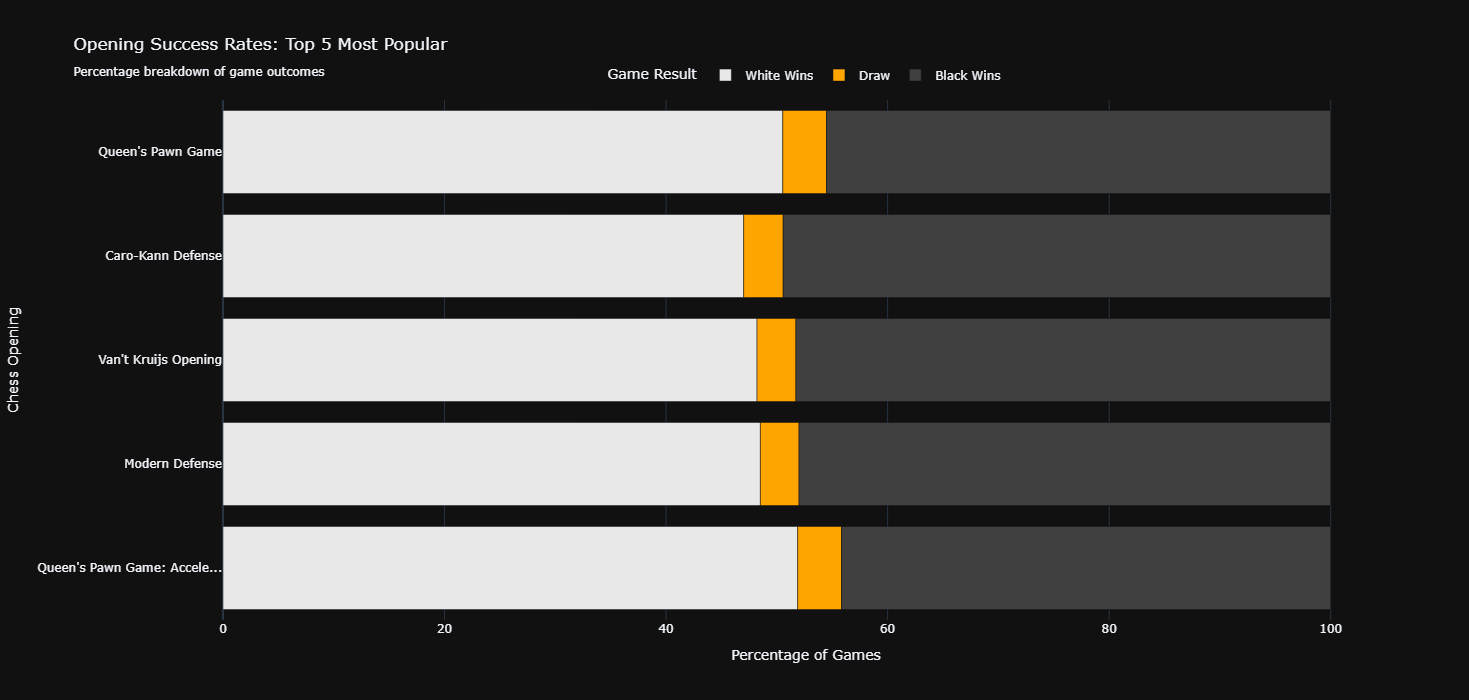


Detailed Opening Analysis:
----------------------------------------

Queen's Pawn Game: Accelerated...
  Total Games: 52,089
  White Wins:   51.9%
  Draws:         4.0%
  Black Wins:   44.2%
  White Advantage:  +7.7 percentage points

Modern Defense
  Total Games: 55,001
  White Wins:   48.5%
  Draws:         3.5%
  Black Wins:   48.0%
  White Advantage:  +0.5 percentage points

Van't Kruijs Opening
  Total Games: 58,966
  White Wins:   48.2%
  Draws:         3.5%
  Black Wins:   48.3%
  White Advantage:  -0.1 percentage points

Caro-Kann Defense
  Total Games: 62,020
  White Wins:   47.0%
  Draws:         3.6%
  Black Wins:   49.4%
  White Advantage:  -2.4 percentage points

Queen's Pawn Game
  Total Games: 90,334
  White Wins:   50.5%
  Draws:         3.9%
  Black Wins:   45.5%
  White Advantage:  +5.0 percentage points

Analysis completed in 3.6 seconds
💾 Memory usage: 265 MB


264.515625

In [23]:
import plotly.express as px
import pandas as pd
from pyspark.sql.functions import col
import time

print("="*60)
print("CHESS OPENING ANALYSIS")
print("="*60)

start_time = time.time()
check_memory()

# Get top openings with more detailed analysis
print("Finding most popular openings...")
top_openings_data = df.groupBy("Opening").count().orderBy("count", ascending=False).limit(10).collect()

# Show all top 10 for context, but analyze top 5
print("Top 10 most popular openings:")
for i, row in enumerate(top_openings_data):
    # Fix: Use square brackets instead of dot notation
    print(f"  {i+1:2}. {row['Opening']}: {row['count']:,} games")

# Get top 5 for detailed analysis  
top_openings_list = [row['Opening'] for row in top_openings_data[:5]]  # Also fix this line
df_top_openings = df.filter(col("Opening").isin(top_openings_list))

# Calculate win rate statistics
print("\nAnalyzing win rates for top 5 openings...")
win_rate_stats = df_top_openings.groupBy("Opening").pivot("Result", ["1-0", "0-1", "1/2-1/2"]).count().na.fill(0)
win_rate_pd = win_rate_stats.withColumn("TotalGames", col("1-0") + col("0-1") + col("1/2-1/2")).toPandas()

# Calculate percentages with better precision
win_rate_pd['White Wins'] = (win_rate_pd['1-0'] / win_rate_pd['TotalGames']) * 100
win_rate_pd['Draw'] = (win_rate_pd['1/2-1/2'] / win_rate_pd['TotalGames']) * 100
win_rate_pd['Black Wins'] = (win_rate_pd['0-1'] / win_rate_pd['TotalGames']) * 100
win_rate_pd['White Advantage'] = win_rate_pd['White Wins'] - win_rate_pd['Black Wins']

# Sort by total games for better display order
win_rate_pd = win_rate_pd.sort_values('TotalGames', ascending=True)

# Create enhanced opening names (shortened for display)
win_rate_pd['DisplayName'] = win_rate_pd['Opening'].apply(lambda x: x[:25] + "..." if len(x) > 25 else x)

# Melt the DataFrame from wide to long format
plot_data = win_rate_pd.melt(
    id_vars=['Opening', 'DisplayName', 'TotalGames', 'White Advantage'], 
    value_vars=['White Wins', 'Draw', 'Black Wins'],
    var_name='Result', 
    value_name='Percentage'
)

# Enhanced color scheme for chess results
color_map = {
    'White Wins': '#E8E8E8',  # Light (white pieces)
    'Black Wins': '#404040',  # Dark (black pieces)  
    'Draw': '#FFA500'         # Orange (neutral)
}

# Create enhanced stacked bar chart
fig = px.bar(
    plot_data,
    y="DisplayName",
    x="Percentage",
    color="Result",
    title="Opening Success Rates: Top 5 Most Popular<br><sub>Percentage breakdown of game outcomes</sub>",
    orientation='h',
    template="plotly_dark",
    height=700,
    color_discrete_map=color_map
)

fig.update_layout(
    xaxis_title="Percentage of Games",
    yaxis_title="Chess Opening",
    legend_title="Game Result",
    font=dict(size=12),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5)
)

fig.show()

# Detailed analysis
print("\nDetailed Opening Analysis:")
print("-" * 40)
for _, row in win_rate_pd.iterrows():
    opening_name = row['Opening'][:30] + "..." if len(row['Opening']) > 30 else row['Opening']
    print(f"\n{opening_name}")
    print(f"  Total Games: {row['TotalGames']:,}")
    print(f"  White Wins:  {row['White Wins']:5.1f}%")
    print(f"  Draws:       {row['Draw']:5.1f}%") 
    print(f"  Black Wins:  {row['Black Wins']:5.1f}%")
    print(f"  White Advantage: {row['White Advantage']:+5.1f} percentage points")

end_time = time.time()
print(f"\nAnalysis completed in {end_time - start_time:.1f} seconds")
check_memory()

OPENING PREFERENCES BY SKILL LEVEL
💾 Memory usage: 299 MB
Classifying players by skill level...


Player skill distribution (3,297,234 games):
  Intermediate: 1,605,388 games ( 48.7%)
  Advanced    : 976,410 games ( 29.6%)
  Beginner    : 436,478 games ( 13.2%)
  Master      : 278,958 games (  8.5%)

Finding top openings for each skill level...


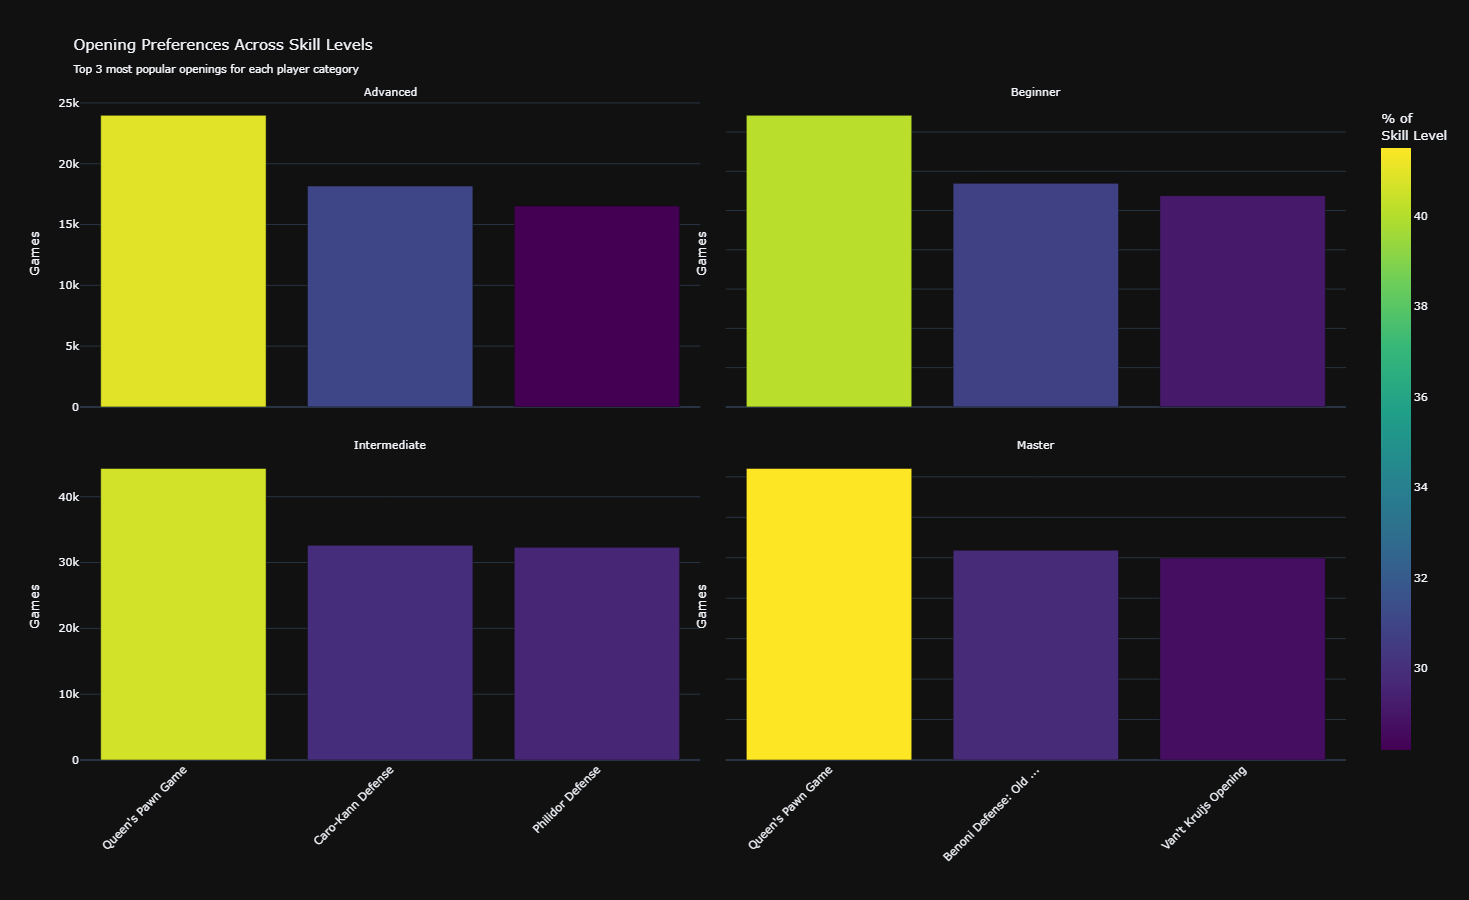


Detailed Opening Analysis by Skill Level:
--------------------------------------------------

Beginner Players:
  1. Queen's Pawn Game
     14,849 games (40.1% of beginner games)
  2. Scandinavian Defense
     11,385 games (30.8% of beginner games)
  3. Philidor Defense
     10,760 games (29.1% of beginner games)

Intermediate Players:
  1. Queen's Pawn Game
     44,299 games (40.6% of intermediate games)
  2. Caro-Kann Defense
     32,621 games (29.9% of intermediate games)
  3. Philidor Defense
     32,311 games (29.6% of intermediate games)

Advanced Players:
  1. Queen's Pawn Game
     23,981 games (40.9% of advanced games)
  2. Caro-Kann Defense
     18,166 games (31.0% of advanced games)
  3. Modern Defense
     16,522 games (28.2% of advanced games)

Master Players:
  1. Queen's Pawn Game
     7,208 games (41.5% of master games)
  2. Benoni Defense: Old Benoni
     5,187 games (29.8% of master games)
  3. Van't Kruijs Opening
     4,994 games (28.7% of master games)

Analysis c

299.390625

In [27]:
import plotly.express as px
from pyspark.sql.window import Window
from pyspark.sql.functions import col, rank, when
import time

print("="*60)
print("OPENING PREFERENCES BY SKILL LEVEL")
print("="*60)

start_time = time.time()
check_memory()

# Create skill level classifications with detailed reporting
print("Classifying players by skill level...")
df_with_stats = df.withColumn("AvgElo", (col("WhiteElo") + col("BlackElo")) / 2)

df_with_skill = df_with_stats.withColumn("SkillLevel",
    when(col("AvgElo") < 1200, "Beginner")
    .when((col("AvgElo") >= 1200) & (col("AvgElo") < 1800), "Intermediate")
    .when((col("AvgElo") >= 1800) & (col("AvgElo") < 2200), "Advanced")
    .when(col("AvgElo") >= 2200, "Master")
    .otherwise("Unknown")
).filter(col("SkillLevel") != "Unknown")

# Show skill level distribution (fixed sum issue)
skill_distribution = df_with_skill.groupBy("SkillLevel").count().orderBy("count", ascending=False).collect()
total_classified = 0
for row in skill_distribution:
    total_classified += row['count']

print(f"Player skill distribution ({total_classified:,} games):")
for row in skill_distribution:
    percentage = (row['count'] / total_classified) * 100
    print(f"  {row['SkillLevel']:12}: {row['count']:7,} games ({percentage:5.1f}%)")

# Analyze top openings by skill level
print("\nFinding top openings for each skill level...")
opening_counts_by_skill = df_with_skill.groupBy("SkillLevel", "Opening").count()
windowSpec = Window.partitionBy("SkillLevel").orderBy(col("count").desc())
top_openings_by_skill = opening_counts_by_skill.withColumn("rank", rank().over(windowSpec)).filter(col("rank") <= 3)
top_openings_pd = top_openings_by_skill.toPandas()

# Add percentage within skill level for better insights
for skill in top_openings_pd['SkillLevel'].unique():
    skill_mask = top_openings_pd['SkillLevel'] == skill
    skill_total = top_openings_pd[skill_mask]['count'].sum()
    top_openings_pd.loc[skill_mask, 'percentage'] = (top_openings_pd.loc[skill_mask, 'count'] / skill_total * 100).round(1)

# Truncate long opening names for better display
top_openings_pd['ShortOpening'] = top_openings_pd['Opening'].apply(
    lambda x: x[:20] + "..." if len(x) > 20 else x
)

# Create enhanced faceted bar chart
fig = px.bar(
    top_openings_pd,
    x="ShortOpening",
    y="count",
    facet_col="SkillLevel",
    facet_col_wrap=2,
    title="Opening Preferences Across Skill Levels<br><sub>Top 3 most popular openings for each player category</sub>",
    template="plotly_dark",
    labels={'count': 'Number of Games', 'ShortOpening': 'Opening'},
    height=900,
    color='percentage',
    color_continuous_scale='Viridis'
)

# Clean up subplot titles and formatting (FIXED: Remove invalid facet spacing properties)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(matches=None, tickangle=-45, title="")
fig.update_yaxes(matches=None, title="Games")

# Fixed layout - removed invalid facet properties
fig.update_layout(
    coloraxis_colorbar=dict(title="% of<br>Skill Level"),
    font=dict(size=11)
)

fig.show()

# Detailed analysis by skill level
print("\nDetailed Opening Analysis by Skill Level:")
print("-" * 50)

skill_order = ["Beginner", "Intermediate", "Advanced", "Master"]
for skill in skill_order:
    skill_data = top_openings_pd[top_openings_pd['SkillLevel'] == skill].sort_values('rank')
    if not skill_data.empty:
        print(f"\n{skill} Players:")
        for _, row in skill_data.iterrows():
            opening_name = row['Opening'][:35] + "..." if len(row['Opening']) > 35 else row['Opening']
            print(f"  {row['rank']:.0f}. {opening_name}")
            print(f"     {row['count']:,} games ({row['percentage']:.1f}% of {skill.lower()} games)")

end_time = time.time()
print(f"\nAnalysis completed in {end_time - start_time:.1f} seconds")
print("="*60)
check_memory()